## Testing BT vs overparameterized model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import re
import json
import time
from datetime import datetime
import os
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
with open('transcript/20250526_000000/evaluations_cleaned.json', 'r') as f:
    data = json.load(f)

In [ ]:
class PairwiseDataset(Dataset):
    def __init__(self, comparisons):
        self.data = comparisons

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        i, j, k, r = self.data[idx]
        return torch.tensor(i, dtype=torch.long), \
               torch.tensor(j, dtype=torch.long), \
               torch.tensor(k, dtype=torch.long), \
               torch.tensor(r, dtype=torch.float32)

class VectorBT(nn.Module):
    def __init__(self, num_models, d):
        super().__init__()
        # judge embeddings u_i and model embeddings v_j
        self.u = nn.Embedding(num_models, d)
        self.v = nn.Embedding(num_models, d)
        # initialize
        nn.init.normal_(self.u.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.v.weight, mean=0.0, std=0.1)

    def forward(self, i_idx, j_idx, k_idx):
        u_i = self.u(i_idx)   # shape: (batch, d)
        v_j = self.v(j_idx)   # shape: (batch, d)
        v_k = self.v(k_idx)   # shape: (batch, d)
        # compute utility differences
        score_j = torch.sum(u_i * v_j, dim=-1)
        score_k = torch.sum(u_i * v_k, dim=-1)
        return torch.sigmoid(score_j - score_k)
    
class VectorBT_norm(nn.Module):
    def __init__(self, num_models, d):
        super().__init__()
        # judge embeddings u_i and model embeddings v_j
        self.u = nn.Embedding(num_models, d)
        self.v = nn.Embedding(num_models, d)
        # initialize
        nn.init.normal_(self.u.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.v.weight, mean=0.0, std=0.1)

    def forward(self, i_idx, j_idx, k_idx):
        u_i = self.u(i_idx)   # shape: (batch, d)
        v_j = self.v(j_idx)   # shape: (batch, d)
        v_k = self.v(k_idx)   # shape: (batch, d)
        # compute utility differences
        # latent strength: negative squared Euclidean distance
        score_j = -torch.sum((u_i - v_j) ** 2, dim=-1)
        score_k = -torch.sum((u_i - v_k) ** 2, dim=-1)
        return torch.sigmoid(score_j - score_k)

class Simple(nn.Module):
    def __init__(self, W):
        super().__init__()
        self.W = nn.Parameter(torch.tensor(W, dtype=torch.float32))

    def forward(self, i_idx, j_idx, k_idx):
        return self.W[i_idx, j_idx, k_idx]


In [ ]:
comparisons = []
for i, item in enumerate(data):
    response = item['judge response']
    eval1_response = item['eval1 response']
    eval2_response = item['eval2 response']

    if response == None or eval1_response == None or eval2_response == None:
        continue

    e = re.search(r"Error in \w+ API call", response)
    e1 = re.search(r"Error in \w+ API call", eval1_response)
    e2 = re.search(r"Error in \w+ API call", eval2_response)
    if e or e1 or e2:
        print(f"Error in {i}th API call")
        continue

    m = re.search(r'<choice>(.)</choice>', response)
    if m:
        try:
            score = int(m.group(1))

            comparisons.append([item['judge'], item['eval1'], item['eval2'], score])
            # data_cleaned.append(item)
        except:
            print(f"No number found in the {i}th judge response")
            continue
    else:
        print(f"No <choice>…</choice> match found in the {i}th judge response")

In [ ]:
from sklearn.model_selection import train_test_split
train_comps, test_comps = train_test_split(
    comparisons,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
train_loader = DataLoader(PairwiseDataset(train_comps), batch_size=32, shuffle=True)
test_loader  = DataLoader(PairwiseDataset(test_comps),  batch_size=32, shuffle=False)

num_models = 5
d = 6

lr = 1e-3
weight_decay = 0
max_epochs = 150

device = 'mps'

In [ ]:
model = VectorBT(num_models, d)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCELoss()

loss_history = []

for epoch in range(1, max_epochs+1):
    total_loss = 0.0
    model.train()

    for i_idx, j_idx, k_idx, r in train_loader:
        i_idx = i_idx.to(device)
        j_idx = j_idx.to(device)
        k_idx = k_idx.to(device)
        r = r.to(device)

        # r = (r+1.0)/2.0 # convert {1,-1} to {1,0}
        r = 2-r # convert {1,2} to {1,0}

        p = model(i_idx, j_idx, k_idx)
        loss = loss_fn(p, r) # cross entropy loss with classifying 0/1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * r.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3d}, Loss = {avg_loss:.4f}")

plt.figure()
plt.plot(range(1, len(loss_history)+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average BCE Loss')
plt.title('Training Loss over Epochs')
plt.tight_layout()
plt.show()

In [ ]:
model = VectorBT_(num_models, d)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCELoss()

loss_history = []

for epoch in range(1, max_epochs+1):
    total_loss = 0.0
    model.train()

    for i_idx, j_idx, k_idx, r in train_loader:
        i_idx = i_idx.to(device)
        j_idx = j_idx.to(device)
        k_idx = k_idx.to(device)
        r = r.to(device)

        # r = (r+1.0)/2.0 # convert {1,-1} to {1,0}
        r = 2-r # convert {1,2} to {1,0}

        p = model(i_idx, j_idx, k_idx)
        loss = loss_fn(p, r) # cross entropy loss with classifying 0/1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * r.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3d}, Loss = {avg_loss:.4f}")

plt.figure()
plt.plot(range(1, len(loss_history)+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average BCE Loss')
plt.title('Training Loss over Epochs')
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
loss_fn = nn.BCELoss()
total_test_loss = 0.0

with torch.no_grad():
    for i_idx, j_idx, k_idx, r in test_loader:
        i_idx, j_idx, k_idx = i_idx.to(device), j_idx.to(device), k_idx.to(device)
        r = (2 - r.to(device))             # {1,2}→{1,0}
        preds = model(i_idx, j_idx, k_idx)
        loss  = loss_fn(preds, r)
        total_test_loss += loss.item() * r.size(0)

avg_test_loss = total_test_loss / len(test_loader.dataset)
print(f"Test BCE Loss = {avg_test_loss:.4f}")

In [ ]:
W = np.zeros((5,5,5))
counts = np.zeros((5,5,5))

for item in train_comps:
    i, j, k, r = item
    W[i,j,k] += 2-r
    counts[i][j][k] += 1
W[counts == 0] = 0.5
W[counts != 0] = W[counts != 0] / counts[counts != 0]

simple = Simple(W)
simple.to(device)

In [ ]:
counts

In [ ]:
simple.eval()
loss_fn = nn.BCELoss()
total_test_loss = 0.0

with torch.no_grad():
    for i_idx, j_idx, k_idx, r in test_loader:
        i_idx, j_idx, k_idx = i_idx.to(device), j_idx.to(device), k_idx.to(device)
        r = (2 - r.to(device)).float()  # {1,2}→{1,0} and ensure it's float
        preds = simple(i_idx, j_idx, k_idx)
        
        loss = loss_fn(preds, r)
        total_test_loss += loss.item() * r.size(0)

avg_test_loss = total_test_loss / len(test_loader.dataset)
print(f"Test BCE Loss = {avg_test_loss:.4f}")

## Testing BT loss on its own predictive entropy

See notes for write-up

In [ ]:
model

In [ ]:
entropy = 0
for i, j, k in [[i,j,k] for i in range(5) for j in range(5) for k in range(5)]:
    i = torch.tensor([i], dtype=torch.long).to(device)
    j = torch.tensor([j], dtype=torch.long).to(device)
    k = torch.tensor([k], dtype=torch.long).to(device)
    p = model(i, j, k)

    entropy -= (p.item() * np.log(p.item())+(1 - p.item()) * np.log(1 - p.item()))* counts[i.item(), j.item(), k.item()]

entropy / np.sum(counts)

In [ ]:
entropy = 0
for i, j, k in [[i,j,k] for i in range(5) for j in range(5) for k in range(5)]:
    i = torch.tensor([i], dtype=torch.long).to(device)
    j = torch.tensor([j], dtype=torch.long).to(device)
    k = torch.tensor([k], dtype=torch.long).to(device)
    p = simple(i, j, k)

    entropy -= (p.item() * np.log(p.item())+(1 - p.item()) * np.log(1 - p.item()))* counts[i.item(), j.item(), k.item()]

entropy / np.sum(counts)

## Testing Bootstrap Resampling for Error Bars

In [ ]:
from BT import *
from eigentrust import *

In [ ]:
path = 'transcript/20250526_000000/'
filepath = path + 'evaluations_cleaned.json'

data = []
with open(filepath, 'r') as file:
    data.extend(json.load(file))

In [ ]:
comparisons = []
for i, item in enumerate(data):
    response = item['judge response']
    eval1_response = item['eval1 response']
    eval2_response = item['eval2 response']

    if response == None or eval1_response == None or eval2_response == None:
        continue

    e = re.search(r"Error in \w+ API call", response)
    e1 = re.search(r"Error in \w+ API call", eval1_response)
    e2 = re.search(r"Error in \w+ API call", eval2_response)
    if e or e1 or e2:
        print(f"Error in {i}th API call")
        continue

    m = re.search(r'<choice>(.)</choice>', response)
    if m:
        try:
            score = int(m.group(1))

            comparisons.append([item['judge'], item['eval1'], item['eval2'], score])
        except:
            print(f"No number found in the {i}th judge response")
            continue
    else:
        print(f"No <choice>…</choice> match found in the {i}th judge response")

print("Formed", len(comparisons), "comparisons\n")

In [ ]:
import random

In [ ]:
def train_trust_matrix(data,epochs):

    batch_size=32
    dataset = PairwiseDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    num_models = 5
    d = 6

    lr = 1e-3
    weight_decay = 0
    max_epochs = epochs

    model = VectorBT(num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='mps'
    )

    device = 'mps'
    S = compute_trust_matrix(model, device)
    C = row_normalize(S)

    return S,C

In [ ]:
trust_matrices = []

for i in tqdm(range(100)):
    sample = random.choices(comparisons, k=len(comparisons))

    epochs = 100

    S,C = train_trust_matrix(sample, epochs=epochs)
    t = eigentrust(C, alpha=0)

    trust_matrices.append([S.cpu().numpy().tolist(),
                           C.cpu().numpy().tolist(),
                           t.cpu().numpy().tolist()])

    with open(f'transcript/20250526_000000/bootstrap/samples.json', "w") as file:
        json.dump(trust_matrices, file, indent=4)

In [ ]:
import json
import numpy as np
data = []
with open(f'transcript/20250526_000000/bootstrap/samples.json', 'r') as file:
    data.extend(json.load(file))

In [ ]:
trust_vectors = np.array([i[2] for i in data])

In [ ]:
np.mean(trust_vectors,axis=0)

In [ ]:
variances = np.var(trust_vectors, axis=0, ddof=1)
std_devs = np.sqrt(variances)

print("Std devs of each model's trust score:")
for j, v in enumerate(std_devs, start=1):
    print(f" Model {j:>2}:  {v:.6f}")

In [ ]:
lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)

# Combine into intervals
cis = list(zip(lower_bounds, upper_bounds))

for j, (lo, hi) in enumerate(cis, start=1):
    print(f"Model {j:>2} 95% CI: [{lo:.4f}, {hi:.4f}]")

In [ ]:
with open(f'transcript/20250526_000000/bootstrap/samples.json', "r") as file:
    data = json.load(file)

In [ ]:
data = [i[2] for i in data]

In [ ]:
data

In [ ]:
import matplotlib.pyplot as plt
plt.hist([i[0] for i in data])
plt.show()

## Entropy for BTD

In [ ]:
import torch
import numpy as np
from BT import VectorBTD, VectorBT
import torch.nn.functional as F

In [ ]:
def load_vector_btd(path, num_models, d, device='cpu'):
    model = VectorBTD(num_models, d).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

path = f'transcript/20250715_000000/loyalty/unit btd d1/'
d = 1
model_path = path + 'model.pt'
num_models = 4
device='cpu'

model = load_vector_btd(model_path, num_models, d)

In [ ]:
entropy = 0
count = 0
for i, j, k in [[i,j,k] for i in range(num_models) for j in range(num_models) for k in range(num_models)]:
    if j != k:
        i = torch.tensor([i], dtype=torch.long).to(device)
        j = torch.tensor([j], dtype=torch.long).to(device)
        k = torch.tensor([k], dtype=torch.long).to(device)
        
        logits = model(i, j, k)
        probs = F.softmax(logits, dim=1)[0]

        entropy -= torch.sum(probs * torch.log(probs))
        count += 1

print(entropy.detach().numpy() / count)

## Retesting BT entropy

In [ ]:
from BT import PairwiseDataset, extract_comparisons
from torch.utils.data import Dataset, DataLoader
import json

In [ ]:
data = []
with open('transcript/20250614_000000/evaluations_cleaned.json', 'r') as file:
    data.extend(json.load(file))

comparisons, data_cleaned = extract_comparisons(data)

In [ ]:
data = DataLoader(PairwiseDataset(comparisons), batch_size=1, shuffle=True)

In [ ]:
def load_vector_bt(path, num_models, d, device='cpu'):
    model = VectorBT(num_models, d).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

path = f'transcript/20250614_000000/classic BT d1/'
d = 1
model_path = path + 'model.pt'
num_models = 5
device='cpu'

model = load_vector_bt(model_path, num_models, d)

In [ ]:
entropy = 0
for i, j, k, r in data:
    p = model(i, j, k)

    entropy -= p.item() * np.log(p.item())+(1 - p.item()) * np.log(1 - p.item())
print(entropy / len(data))

## Testing Bootstrap Resampling for Error Bars: redone 7/27

In [ ]:
from BT_criteria import *
from eigentrust import *
import random

In [ ]:
path = 'transcript/20250726_000000/'
filepath = path + 'comparisons_with_ties.json'

comparisons = []
with open(filepath, 'r') as file:
    comparisons.extend(json.load(file))

In [ ]:
comparisons = [[0] + i[2:] for i in comparisons]  # remove scenario and criteria indices; make every datapoint associated with criterion 0
omissions = [1] # omit these models, must be in reverse order
for k in omissions:
    comparisons = [i for i in comparisons if (i[1]!=k and i[2]!=k and i[3]!=k)]
    for i in comparisons:
        if i[1]>k:
            i[1] -= 1
        if i[2]>k:
            i[2] -= 1
        if i[3]>k:
            i[3] -= 1
num_models = len(set([i[1] for i in comparisons]))
num_criteria = 1

len(comparisons)

In [ ]:
def train_trust_matrix(comparisons,epochs):

    num_models = len(set([i[1] for i in comparisons]))
    num_criteria = 1

    d = 5
    NORMALIZE=False
    USE_BTD=True

    lr = 1e-3
    weight_decay = 0
    max_epochs = epochs

    batch_size=32
    dataloader = DataLoader(dataset = PairwiseDataset(comparisons), batch_size=batch_size, shuffle=True)

    model = VectorBTD(num_criteria, num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='cpu',
        save_path=None,
        normalize=NORMALIZE,
        use_btd=USE_BTD
    )

    device = 'cpu'
    T = compute_trust_matrix_ties(model, device)
    t = eigentrust(T, alpha=0)

    return T,t,model

In [ ]:
trust_matrices = []

for i in tqdm(range(100)):
    sample = random.choices(comparisons, k=len(comparisons))

    epochs = 15

    T,t,model = train_trust_matrix(sample, epochs=epochs)

    trust_matrices.append([T.cpu().numpy().tolist(),
                           t.cpu().numpy().tolist()])

    with open(path + f'omit claude 3.5/bootstrap/samples.json', "w") as file:
        json.dump(trust_matrices, file, indent=4)
    torch.save(model.state_dict(), path + f'omit claude 3.5/bootstrap/model_{i}.pt')

In [ ]:
from BT_criteria import VectorBTD
from eigentrust import compute_trust_matrix_ties, eigentrust
import torch
import json

def load_vector_btd(path, num_criteria, num_models, d, device='cpu'):
    model = VectorBTD(num_criteria, num_models, d).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

trust_matrices = []
for i in range(100):
    model_path = f'transcript/20250726_000000/omit claude 3.5/bootstrap/models/model_{i}.json'
    d = 5
    num_models = 5
    num_criteria = 1
    model = load_vector_btd(model_path, num_criteria, num_models, d)

    T = compute_trust_matrix_ties(model)
    t = eigentrust(T, alpha=0)
    trust_matrices.append([T.cpu().numpy().tolist(),
                        t.cpu().numpy().tolist()])
    
with open(f'transcript/20250726_000000/omit claude 3.5/bootstrap/samples.json', "w") as file:
    json.dump(trust_matrices, file, indent=4)

In [ ]:
import json
import numpy as np
data = []
with open('transcript/20250726_000000/omit claude 3.5/' + f'bootstrap/samples.json', 'r') as file:
# with open('transcript/20250731_200000/' + f'bootstrap/samples.json', 'r') as file:
    data.extend(json.load(file))

In [ ]:
trust_vectors = np.array([i[1] for i in data])

In [ ]:
trust_vectors = [convert_elo(t) for t in trust_vectors]

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,5, figsize=(15,5))
models = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]
for i in range(5):
    ax[i].hist([j[i] for j in trust_vectors])
    ax[i].set_title(models[i])
plt.show()

In [ ]:
np.mean(trust_vectors,axis=0)

In [ ]:
variances = np.var(trust_vectors, axis=0, ddof=1)
std_devs = np.sqrt(variances)

print("Std devs of each model's trust score:")
for j, v in enumerate(std_devs, start=1):
    print(f" Model {j:>2}:  {v:.6f}")

In [ ]:
lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)

# Combine into intervals
cis = list(zip(lower_bounds, upper_bounds))

for j, (lo, hi) in enumerate(cis, start=1):
    print(f"Model {j:>2} 95% CI: [{lo:.4f}, {hi:.4f}]")
    # lo_ = int(1500 + (400/np.log(10)) * np.log(5 * lo))
    # hi_ = int(1500 + (400/np.log(10)) * np.log(5 * hi))
    # print(f"Model {j:>2} 95% CI: [{lo_:.4f}, {hi_:.4f}]")

In [ ]:
upper_bounds

In [17]:
import numpy as np

def convert_elo(t):
    N = len(t) / sum(t)
    return 1500+400*np.log10(N*t)

def convert_elo_simple(t):
    N = len(t)
    return 1500+400*np.log10(N*t)

In [ ]:
convert_elo_simple(upper_bounds), convert_elo_simple(lower_bounds)

In [ ]:
convert_elo(np.array([  0.2093  , 0.1938  , 0.2783  , 0.1584 ,  0.1602]))

In [ ]:
convert_elo_simple(np.array([  0.2422  , 0.1758 ,  0.2868 ,  0.1692 ,  0.1261]))

In [ ]:
convert_elo(np.array([  0.1916 ,  0.1629 ,  0.3010,  0.1791,   0.1653]))

## Testing Bootstrap Resampling for Plot: 8/2

In [ ]:
from BT_criteria import *
from eigentrust import compute_trust_matrix_ties, eigentrust
import random
import numpy as np
import json
from tqdm import tqdm

In [ ]:
def train_vector_bt(model, dataloader, lr, weight_decay, max_epochs, device, save_path=None, normalize=False, use_btd=False):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    if use_btd:
        loss_fn = nn.CrossEntropyLoss()
    else:
        loss_fn = nn.BCELoss()

    loss_history = []

    for epoch in range(1, max_epochs+1):
        total_loss = 0.0
        model.train()

        for c_idx, i_idx, j_idx, k_idx, r in dataloader:
            c_idx = c_idx.to(device)
            i_idx = i_idx.to(device)
            j_idx = j_idx.to(device)
            k_idx = k_idx.to(device)
            r = r.to(device)

            if use_btd:
                r = r.long()  # CrossEntropyLoss expects long tensor
                logits = model(c_idx, i_idx, j_idx, k_idx)
                loss = loss_fn(logits, r) # CE expects logits, unnormalized, as it has built in softmax
            else:
                p = model(i_idx, j_idx, k_idx)
                loss = loss_fn(p, r)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if normalize:
                with torch.no_grad():
                    model.v.weight.data = F.normalize(model.v.weight.data, p=2, dim=1)

            total_loss += loss.item() * r.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)

        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch:>3d}, Loss = {avg_loss:.4f}")

        if len(loss_history) > 10 and np.abs(np.average(np.diff(loss_history[-10:]))) < 1e-5:
            # print('Converged! Breaking...')
            break
        
    plt.plot(loss_history)

    return loss_history

In [ ]:
path = 'transcript/20250726_000000/'
filepath = path + 'comparisons_with_ties.json'

comparisons = []
with open(filepath, 'r') as file:
    comparisons.extend(json.load(file))

In [ ]:
comparisons = [[0] + i[2:] for i in comparisons]  # remove scenario and criteria indices; make every datapoint associated with criterion 0
omissions = [1] # omit these models, must be in reverse order
for k in omissions:
    comparisons = [i for i in comparisons if (i[1]!=k and i[2]!=k and i[3]!=k)]
    for i in comparisons:
        if i[1]>k:
            i[1] -= 1
        if i[2]>k:
            i[2] -= 1
        if i[3]>k:
            i[3] -= 1
num_models = len(set([i[1] for i in comparisons]))
num_criteria = 1

len(comparisons)

In [ ]:
def train_trust_matrix(comparisons,epochs):

    num_models = 5
    num_criteria = 1

    d = 5
    NORMALIZE=False
    USE_BTD=True

    lr = 1e-3
    weight_decay = 0
    max_epochs = epochs

    batch_size=32
    dataloader = DataLoader(dataset = PairwiseDataset(comparisons), batch_size=batch_size, shuffle=True)

    model = VectorBTD(num_criteria, num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='cpu',
        save_path=None,
        normalize=NORMALIZE,
        use_btd=USE_BTD
    )

    device = 'cpu'
    T = compute_trust_matrix_ties(model, device)
    t = eigentrust(T, alpha=0, verbose=False)

    return T,t,model

In [ ]:
N = 16000
subset = random.choices(comparisons, k=N)

k = 10

for iter in range(k):
    print(f'\n\nNow testing N={N}, iteration {iter}/{k}\n\n')

    trust_data = []

    for i in tqdm(range(100)):
        sample = random.choices(subset, k=len(subset))

        epochs = 10000

        T,t,model = train_trust_matrix(sample, epochs=epochs)

        trust_data.append([T.tolist(),t.tolist()])

    trust_vectors = np.array([i[1] for i in trust_data])
    lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
    upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)
    
    bootstrap_interval = upper_bounds - lower_bounds
    
    if not os.path.exists(f'bootstrap/{N}'):
        os.makedirs(f'bootstrap/{N}')

    with open(f'bootstrap/{N}/trust_data_{iter}.json', "w") as file:
        json.dump([trust_data,bootstrap_interval.tolist()], file, indent=4)

In [ ]:
np.mean(trust_vectors,axis=0)

In [ ]:
x=[0, 1, 4, 1, 4, 4, 4, 2, 1, 2, 2, 4, 1, 1, 1, 2, 1, 4, 2, 4, 2, 4, 2, 4,
        4, 2, 4, 2, 4, 1, 2, 0]
a=[4, 4, 4, 0, 0, 3, 3, 4, 0, 1, 3, 3, 2, 0, 4, 1, 2, 0, 1, 1, 1, 2, 2, 3,
        3, 3, 2, 4, 0, 4, 0, 2]
b=[2, 0, 3, 3, 2, 0, 0, 1, 1, 0, 2, 4, 1, 3, 0, 0, 0, 1, 4, 4, 0, 0, 0, 4,
        4, 1, 1, 3, 3, 3, 3, 4]
c=[2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0,
        2, 2, 1, 2, 1, 2, 1, 0]
[i for i in x if i not in range(5)]

In [ ]:
variances = np.var(trust_vectors, axis=0, ddof=1)
std_devs = np.sqrt(variances)

print("Std devs of each model's trust score:")
for j, v in enumerate(std_devs, start=1):
    print(f" Model {j:>2}:  {v:.6f}")

In [ ]:
lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)

# Combine into intervals
cis = list(zip(lower_bounds, upper_bounds))

for j, (lo, hi) in enumerate(cis, start=1):
    print(f"Model {j:>2} 95% CI: [{lo:.4f}, {hi:.4f}]")
    # lo_ = int(1500 + (400/np.log(10)) * np.log(5 * lo))
    # hi_ = int(1500 + (400/np.log(10)) * np.log(5 * hi))
    # print(f"Model {j:>2} 95% CI: [{lo_:.4f}, {hi_:.4f}]")

In [ ]:
import numpy as np

def convert_elo(t):
    N = len(t) / sum(t)
    return 1500+400*np.log10(N*t)

def convert_elo_simple(t):
    N = len(t)
    return 1500+400*np.log10(N*t)

## Making bootstrap CIs plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ci_125 = [0.57755141, 0.18777773, 0.38483603, 0.24194619, 0.14817229]
ci_250 = [0.15723947, 0.16138816, 0.29021568, 0.11275995, 0.06939339]
ci_500 = [0.09389715, 0.0926487, 0.11443901, 0.10895055, 0.04380975]
ci_1000 = [0.0639785, 0.04718881, 0.08185545, 0.05037303, 0.03234705]
ci_2000 = [0.04382142, 0.03844595, 0.05164954, 0.04544182, 0.02595212]
ci_4000 = [0.03668271, 0.02494722, 0.03730386, 0.02592276, 0.01846793]
ci_8000 = [0.02106122, 0.0160628, 0.02641233, 0.01770195, 0.0127603]
ci_16000 = [0.01535901, 0.01210066, 0.01890316, 0.01188188, 0.00929418]
ci_32000 = [0.01152758, 0.00963727, 0.0151646, 0.01025196, 0.00734711]

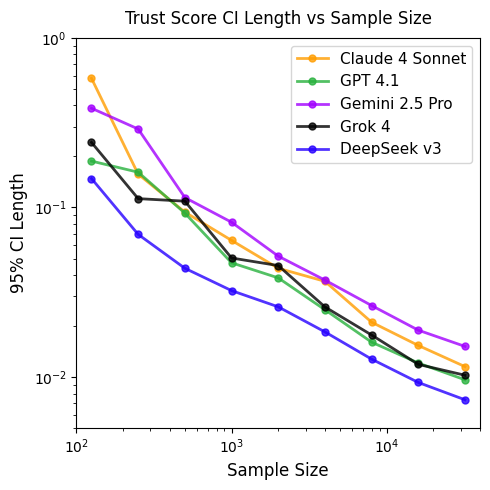

In [118]:
data_points = [125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000]

# Organize data by model
["Claude 4 Sonnet", "Claude 3.5 Haiku", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]
models = {
    "Claude 4 Sonnet": [ci_125[0], ci_250[0], ci_500[0], ci_1000[0], ci_2000[0], 
                ci_4000[0], ci_8000[0], ci_16000[0], ci_32000[0]],
    "GPT 4.1": [ci_125[1], ci_250[1], ci_500[1], ci_1000[1], ci_2000[1], 
                ci_4000[1], ci_8000[1], ci_16000[1], ci_32000[1]],
    "Gemini 2.5 Pro": [ci_125[2], ci_250[2], ci_500[2], ci_1000[2], ci_2000[2], 
                ci_4000[2], ci_8000[2], ci_16000[2], ci_32000[2]],
    "Grok 4": [ci_125[3], ci_250[3], ci_500[3], ci_1000[3], ci_2000[3], 
                ci_4000[3], ci_8000[3], ci_16000[3], ci_32000[3]],
    "DeepSeek v3": [ci_125[4], ci_250[4], ci_500[4], ci_1000[4], ci_2000[4], 
                ci_4000[4], ci_8000[4], ci_16000[4], ci_32000[4]]
}

# Colors for each model
colors = ["#ff9d00", "#28B13DFF", "#a100fe", "#000000", "#2600ff"]

# Create the plot
plt.figure(figsize=(5,5))

# Plot each model
for i, (model_name, ci_values) in enumerate(models.items()):
    plt.loglog(data_points, ci_values, 'o-', 
               color=colors[i], linewidth=2, markersize=5, 
               label=model_name, alpha=0.8)

# Customize the plot
plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('95% CI Length', fontsize=12)
plt.title('Trust Score CI Length vs Sample Size', fontsize=12, pad=10)

# Add grid
# plt.grid(True, which="both", ls="-", alpha=0.3)

# Add legend
plt.legend(fontsize=11, loc='upper right')

# Set axis limits for better visualization
plt.xlim(100, 40000)
plt.ylim(0.005, 1)

# Improve tick formatting
plt.gca().tick_params(axis='both', which='major', labelsize=10)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Show the plot
# plt.savefig('figure.png', dpi=500)
plt.show()


Finding optimal shared exponent α...

Constrained Power Law Fit: CI = C_i × n^α
Optimal shared exponent: α = -0.5751
Total SSE: 1.764669
Overall R²: 0.9643

Model-specific coefficients:
Model 1: C_1 = 4.1906
Model 2: C_2 = 3.1321
Model 3: C_3 = 4.9729
Model 4: C_4 = 3.2995
Model 5: C_5 = 2.0841

Fitted equations:
Model 1: CI = 4.1906 × n^(-0.5751)
Model 2: CI = 3.1321 × n^(-0.5751)
Model 3: CI = 4.9729 × n^(-0.5751)
Model 4: CI = 3.2995 × n^(-0.5751)
Model 5: CI = 2.0841 × n^(-0.5751)

Comparison with individual fits:
Shared α = -0.5751 vs individual α range: [-0.6295, -0.5067]
Standard deviation of individual αs: 0.0404


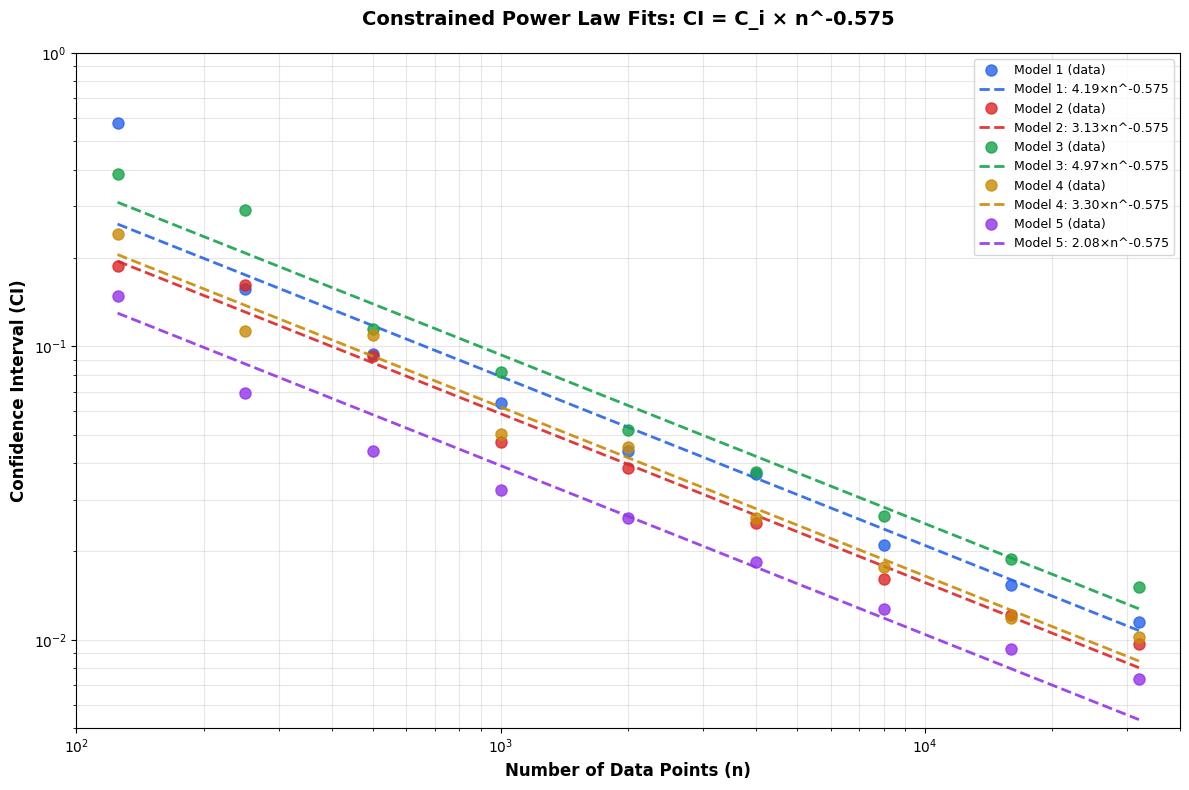


Predictions for n=10,000:
Model 1: CI = 0.02098
Model 2: CI = 0.01568
Model 3: CI = 0.02490
Model 4: CI = 0.01652
Model 5: CI = 0.01044

Theoretical note: α = -0.5751 ≈ -0.5 suggests CI ∝ 1/√n scaling


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy import stats

# Data
ci_125 = [0.57755141, 0.18777773, 0.38483603, 0.24194619, 0.14817229]
ci_250 = [0.15723947, 0.16138816, 0.29021568, 0.11275995, 0.06939339]
ci_500 = [0.09389715, 0.0926487, 0.11443901, 0.10895055, 0.04380975]
ci_1000 = [0.0639785, 0.04718881, 0.08185545, 0.05037303, 0.03234705]
ci_2000 = [0.04382142, 0.03844595, 0.05164954, 0.04544182, 0.02595212]
ci_4000 = [0.03668271, 0.02494722, 0.03730386, 0.02592276, 0.01846793]
ci_8000 = [0.02106122, 0.0160628, 0.02641233, 0.01770195, 0.0127603]
ci_16000 = [0.01535901, 0.01210066, 0.01890316, 0.01188188, 0.00929418]
ci_32000 = [0.01152758, 0.00963727, 0.0151646, 0.01025196, 0.00734711]

# Number of data points
data_points = np.array([125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000])

# Organize data by model
all_ci_data = [ci_125, ci_250, ci_500, ci_1000, ci_2000, ci_4000, ci_8000, ci_16000, ci_32000]
models_data = {}
for model in range(5):
    models_data[f'Model {model+1}'] = [all_ci_data[i][model] for i in range(len(data_points))]

def fit_constrained_power_law(alpha):
    """
    For a given alpha, find the best coefficients C_i for each model
    and return the total sum of squared errors.
    
    Model: CI = C_i * n^alpha
    """
    total_sse = 0
    coefficients = []
    
    log_n = np.log(data_points)
    
    for model in range(5):
        ci_values = np.array([all_ci_data[i][model] for i in range(len(data_points))])
        log_ci = np.log(ci_values)
        
        # For this alpha, find optimal log(C_i) using least squares
        # log(CI) = log(C_i) + alpha * log(n)
        # Rearranging: log(C_i) = log(CI) - alpha * log(n)
        log_C_i = np.mean(log_ci - alpha * log_n)
        C_i = np.exp(log_C_i)
        coefficients.append(C_i)
        
        # Calculate SSE for this model
        predicted_log_ci = log_C_i + alpha * log_n
        sse = np.sum((log_ci - predicted_log_ci)**2)
        total_sse += sse
    
    return total_sse, coefficients

def objective_function(alpha):
    """Objective function to minimize (total SSE across all models)"""
    sse, _ = fit_constrained_power_law(alpha)
    return sse

# Find optimal alpha using optimization
print("Finding optimal shared exponent α...")
result = minimize_scalar(objective_function, bounds=(-1.0, -0.1), method='bounded')
optimal_alpha = result.x
min_sse, optimal_coefficients = fit_constrained_power_law(optimal_alpha)

# Calculate R-squared for the constrained fit
total_variance = 0
for model in range(5):
    ci_values = np.array([all_ci_data[i][model] for i in range(len(data_points))])
    log_ci = np.log(ci_values)
    total_variance += np.sum((log_ci - np.mean(log_ci))**2)

r_squared = 1 - min_sse / total_variance

# Print results
print("\nConstrained Power Law Fit: CI = C_i × n^α")
print("=" * 50)
print(f"Optimal shared exponent: α = {optimal_alpha:.4f}")
print(f"Total SSE: {min_sse:.6f}")
print(f"Overall R²: {r_squared:.4f}")
print("\nModel-specific coefficients:")
for i in range(5):
    print(f"Model {i+1}: C_{i+1} = {optimal_coefficients[i]:.4f}")

print("\nFitted equations:")
for i in range(5):
    print(f"Model {i+1}: CI = {optimal_coefficients[i]:.4f} × n^({optimal_alpha:.4f})")

# Compare with individual fits
print(f"\nComparison with individual fits:")
print(f"Shared α = {optimal_alpha:.4f} vs individual α range: [", end="")

individual_alphas = []
for model in range(5):
    ci_values = np.array([all_ci_data[i][model] for i in range(len(data_points))])
    log_n = np.log(data_points)
    log_ci = np.log(ci_values)
    slope, _, _, _, _ = stats.linregress(log_n, log_ci)
    individual_alphas.append(slope)

print(f"{min(individual_alphas):.4f}, {max(individual_alphas):.4f}]")
print(f"Standard deviation of individual αs: {np.std(individual_alphas):.4f}")

# Plotting
colors = ['#2563eb', '#dc2626', '#16a34a', '#ca8a04', '#9333ea']

plt.figure(figsize=(12, 8))

for i in range(5):
    model_name = f'Model {i+1}'
    ci_values = np.array([all_ci_data[j][i] for j in range(len(data_points))])
    
    # Plot data points
    plt.loglog(data_points, ci_values, 'o', color=colors[i], 
               markersize=8, label=f'{model_name} (data)', alpha=0.8)
    
    # Plot constrained fit
    x_fit = np.logspace(np.log10(data_points.min()), np.log10(data_points.max()), 100)
    y_fit = optimal_coefficients[i] * x_fit**optimal_alpha
    
    plt.loglog(x_fit, y_fit, '--', color=colors[i], linewidth=2,
               label=f'{model_name}: {optimal_coefficients[i]:.2f}×n^{optimal_alpha:.3f}', alpha=0.9)

plt.xlabel('Number of Data Points (n)', fontsize=12, fontweight='bold')
plt.ylabel('Confidence Interval (CI)', fontsize=12, fontweight='bold')
plt.title(f'Constrained Power Law Fits: CI = C_i × n^{optimal_alpha:.3f}', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend(fontsize=9, loc='upper right')
plt.xlim(100, 40000)
plt.ylim(0.005, 1)
plt.tight_layout()
plt.show()

# Print predictions for specific sample sizes
print(f"\nPredictions for n=10,000:")
for i in range(5):
    pred = optimal_coefficients[i] * (10000**optimal_alpha)
    print(f"Model {i+1}: CI = {pred:.5f}")

print(f"\nTheoretical note: α = {optimal_alpha:.4f} ≈ -0.5 suggests CI ∝ 1/√n scaling")

## Bootstrap for ICLR paper 9/23:

In [ ]:
from BT_criteria import *
from eigentrust import *
import random
from data_utils import *

In [ ]:
path = 'transcript/20250923_000000/'
filepath = path + 'evaluations.json'
import json
evaluations = []
with open(filepath, 'r') as file:
    evaluations.extend(json.load(file))

In [ ]:
comparisons, data_cleaned = extract_comparisons_with_ties_criteria(evaluations, num_criteria=8)
comparisons = handle_inconsistencies_with_ties_criteria(comparisons)
comparisons = [[0] + i[1:] for i in comparisons]

In [ ]:
len(comparisons), len([i for i in comparisons if i[2] in [5,6,7] or i[3] in [5,6,7] or i[4] in [5,6,7]])

In [ ]:
A = np.zeros((8,8,8))

In [ ]:
for datapt in comparisons:
    c, s, i, j, k, r = datapt
    A[i,j,k] +=1

In [ ]:
def train_trust_matrix(comparisons):

    num_models = 8
    num_criteria = 1

    d = 2
    NORMALIZE=False
    USE_BTD=True

    lr = 1e-3
    weight_decay = 0
    max_epochs = 1000

    batch_size=32
    dataloader = DataLoader(Comparisons(comparisons), batch_size=batch_size, shuffle=True)

    model = VectorBTD(num_criteria, num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='cpu',
        save_path=None,
        normalize=NORMALIZE,
        use_btd=USE_BTD
    )

    device = 'cpu'
    T = compute_trust_matrix_ties(model, device)
    t = eigentrust(T, alpha=0)

    return T,t,model

In [ ]:
trust_matrices = []

for i in tqdm(range(100)):
    sample = random.choices(comparisons, k=len(comparisons))

    T,t,model = train_trust_matrix(sample)

    trust_matrices.append([T.cpu().numpy().tolist(),
                           t.cpu().numpy().tolist()])

    with open(path + f'bootstrap/samples.json', "w") as file:
        json.dump(trust_matrices, file, indent=4)
    torch.save(model.state_dict(), path + f'bootstrap/model_{i}.pt')

In [ ]:
import json
import numpy as np
data = []
with open('transcript/20250923_000000/' + f'bootstrap/samples.json', 'r') as file:
    data.extend(json.load(file))

In [ ]:
trust_vectors = np.array([i[1] for i in data])

In [ ]:
trust_vectors = [convert_elo(t) for t in trust_vectors]

In [ ]:
np.mean(trust_vectors,axis=0)

In [ ]:
variances = np.var(trust_vectors, axis=0, ddof=1)
std_devs = np.sqrt(variances)

print("Std devs of each model's trust score:")
for j, v in enumerate(std_devs, start=1):
    print(f" Model {j:>2}:  {v:.6f}")

In [ ]:
lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)

# Combine into intervals
cis = list(zip(lower_bounds, upper_bounds))

for j, (lo, hi) in enumerate(cis, start=1):
    print(f"Model {j:>2} 95% CI: [{lo:.4f}, {hi:.4f}]")
    # lo_ = int(1500 + (400/np.log(10)) * np.log(5 * lo))
    # hi_ = int(1500 + (400/np.log(10)) * np.log(5 * hi))
    # print(f"Model {j:>2} 95% CI: [{lo_:.4f}, {hi_:.4f}]")

In [ ]:
lower_bounds, upper_bounds

In [ ]:
a1 = np.array([  0.1402,   0.1288,   0.1287 ,  0.1474  , 0.1368  , 0.0949 ,  0.0878 ,  0.1354])
convert_elo(a1)

## Bootstrap for ICLR Reviews 11/19 (39 models):

In [67]:
import numpy as np

def convert_elo(t):
    N = len(t) / sum(t)
    return 1500+400*np.log10(N*t)

In [68]:
from BT_criteria import *
from eigentrust import *
import random
from data_utils import *

In [110]:
path = 'transcript/20251119_000000/'
filepath = path + 'evaluations.json'
import json
evaluations = []
with open(filepath, 'r') as file:
    evaluations.extend(json.load(file))

In [111]:
comparisons, data_cleaned = extract_comparisons_with_ties_criteria(evaluations, num_criteria=8)
comparisons = handle_inconsistencies_with_ties_criteria(comparisons)
comparisons = [[0] + i[1:] for i in comparisons]

num_models = len(set([i[2] for i in comparisons ] + [i[3] for i in comparisons] + [i[4] for i in comparisons]))
num_criteria = len(set([i[0] for i in comparisons]))

Number of comparisons with a null response: 748
Number of comparisons with an API call error: 579
Number of judge responses missing a specific <criterion> match: 5848
Number of judge responses missing a number in the <criterion> match: 0
Number of judge responses with a non-0/1/2 number in the <criterion> match: 0

Total comparisons generated: 137096/153560


In [71]:
def train_trust_matrix(comparisons):
    d = 2
    NORMALIZE=False
    USE_BTD=True

    lr = 1e-3
    weight_decay = 0
    max_epochs = 1000

    batch_size=32
    dataloader = DataLoader(Comparisons(comparisons), batch_size=batch_size, shuffle=True)

    model = VectorBTD(num_criteria, num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='cpu',
        save_path=None,
        normalize=NORMALIZE,
        use_btd=USE_BTD
    )

    device = 'cpu'
    T = compute_trust_matrix_ties(model, device)
    t = eigentrust(T, alpha=0)

    return T,t,model

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch  10, Loss = 0.9960
loss converged, breaking


  1%|          | 1/100 [00:47<1:18:27, 47.55s/it]

Epoch  10, Loss = 0.9980
loss converged, breaking


  2%|▏         | 2/100 [01:40<1:22:31, 50.52s/it]

Epoch  10, Loss = 0.9945
loss converged, breaking


  3%|▎         | 3/100 [02:24<1:16:56, 47.59s/it]

Epoch  10, Loss = 0.9969
loss converged, breaking


  4%|▍         | 4/100 [03:24<1:24:17, 52.68s/it]

Epoch  10, Loss = 0.9934
loss converged, breaking


  5%|▌         | 5/100 [04:17<1:23:17, 52.60s/it]

Epoch  10, Loss = 0.9944
loss converged, breaking


  6%|▌         | 6/100 [05:14<1:24:58, 54.23s/it]

Epoch  10, Loss = 0.9955
loss converged, breaking


  7%|▋         | 7/100 [06:22<1:31:09, 58.81s/it]

Epoch  10, Loss = 0.9959
loss converged, breaking


  8%|▊         | 8/100 [07:13<1:26:09, 56.19s/it]

Epoch  10, Loss = 0.9984
loss converged, breaking


  9%|▉         | 9/100 [08:10<1:25:48, 56.58s/it]

Epoch  10, Loss = 0.9967
loss converged, breaking


 10%|█         | 10/100 [09:14<1:28:16, 58.85s/it]

Epoch  10, Loss = 0.9967
Epoch  20, Loss = 0.9938
loss converged, breaking


 11%|█         | 11/100 [10:45<1:41:54, 68.71s/it]

Epoch  10, Loss = 0.9946
loss converged, breaking


 12%|█▏        | 12/100 [11:42<1:35:22, 65.03s/it]

Epoch  10, Loss = 0.9957
loss converged, breaking


 13%|█▎        | 13/100 [39:43<13:24:11, 554.62s/it]

Epoch  10, Loss = 0.9926
loss converged, breaking


 14%|█▍        | 14/100 [40:37<9:38:06, 403.34s/it] 

Epoch  10, Loss = 0.9930
loss converged, breaking


 15%|█▌        | 15/100 [41:41<7:06:42, 301.21s/it]

Epoch  10, Loss = 0.9960
loss converged, breaking


 16%|█▌        | 16/100 [42:36<5:17:42, 226.94s/it]

Epoch  10, Loss = 0.9933
loss converged, breaking


 17%|█▋        | 17/100 [43:22<3:58:54, 172.70s/it]

Epoch  10, Loss = 0.9969
loss converged, breaking


 18%|█▊        | 18/100 [44:15<3:06:52, 136.74s/it]

Epoch  10, Loss = 0.9968
Epoch  20, Loss = 0.9955
loss converged, breaking


 19%|█▉        | 19/100 [45:25<2:37:18, 116.53s/it]

Epoch  10, Loss = 0.9971
loss converged, breaking


 20%|██        | 20/100 [46:24<2:12:23, 99.29s/it] 

Epoch  10, Loss = 0.9942


/Users/jchang153/Documents/GitHub/EigenBench/BT_criteria.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


loss converged, breaking


 21%|██        | 21/100 [47:07<1:48:39, 82.53s/it]

Epoch  10, Loss = 0.9943
loss converged, breaking


 22%|██▏       | 22/100 [48:07<1:38:23, 75.69s/it]

Epoch  10, Loss = 0.9938
loss converged, breaking


 23%|██▎       | 23/100 [49:00<1:28:25, 68.91s/it]

Epoch  10, Loss = 0.9954
Epoch  20, Loss = 0.9942
loss converged, breaking


 24%|██▍       | 24/100 [50:10<1:27:30, 69.08s/it]

Epoch  10, Loss = 0.9942
loss converged, breaking


 25%|██▌       | 25/100 [51:03<1:20:16, 64.22s/it]

Epoch  10, Loss = 0.9990
loss converged, breaking


 26%|██▌       | 26/100 [51:59<1:16:19, 61.88s/it]

Epoch  10, Loss = 0.9982
Epoch  20, Loss = 0.9965
Epoch  30, Loss = 0.9945
loss converged, breaking


 27%|██▋       | 27/100 [53:51<1:33:31, 76.87s/it]

Epoch  10, Loss = 0.9935
loss converged, breaking


 28%|██▊       | 28/100 [54:37<1:21:12, 67.67s/it]

Epoch  10, Loss = 0.9977
loss converged, breaking


 29%|██▉       | 29/100 [1:00:52<3:08:59, 159.71s/it]

Epoch  10, Loss = 0.9935
loss converged, breaking


 30%|███       | 30/100 [1:16:41<7:42:40, 396.58s/it]

Epoch  10, Loss = 0.9928
loss converged, breaking


 31%|███       | 31/100 [1:32:23<10:44:25, 560.36s/it]

Epoch  10, Loss = 0.9970
Epoch  20, Loss = 0.9959
loss converged, breaking


 32%|███▏      | 32/100 [1:33:33<7:48:18, 413.21s/it] 

Epoch  10, Loss = 0.9947
loss converged, breaking


 33%|███▎      | 33/100 [1:34:19<5:38:21, 303.00s/it]

Epoch  10, Loss = 0.9946
loss converged, breaking


 34%|███▍      | 34/100 [1:35:14<4:11:19, 228.47s/it]

Epoch  10, Loss = 0.9968
loss converged, breaking


 35%|███▌      | 35/100 [1:36:11<3:11:50, 177.08s/it]

Epoch  10, Loss = 0.9969
loss converged, breaking


 36%|███▌      | 36/100 [1:37:00<2:28:05, 138.84s/it]

Epoch  10, Loss = 0.9965
loss converged, breaking


 37%|███▋      | 37/100 [1:37:56<1:59:32, 113.86s/it]

Epoch  10, Loss = 0.9943
loss converged, breaking


 38%|███▊      | 38/100 [1:39:13<1:46:04, 102.66s/it]

Epoch  10, Loss = 0.9919
loss converged, breaking


 39%|███▉      | 39/100 [1:40:04<1:28:47, 87.33s/it] 

Epoch  10, Loss = 0.9964
loss converged, breaking


 40%|████      | 40/100 [1:40:59<1:17:42, 77.71s/it]

Epoch  10, Loss = 0.9972
loss converged, breaking


 41%|████      | 41/100 [1:42:10<1:14:11, 75.45s/it]

Epoch  10, Loss = 0.9952
loss converged, breaking


 42%|████▏     | 42/100 [1:43:00<1:05:35, 67.85s/it]

Epoch  10, Loss = 0.9969
loss converged, breaking


 43%|████▎     | 43/100 [1:44:21<1:08:10, 71.76s/it]

Epoch  10, Loss = 0.9941
loss converged, breaking


 44%|████▍     | 44/100 [1:45:22<1:04:08, 68.72s/it]

Epoch  10, Loss = 0.9954
loss converged, breaking


 45%|████▌     | 45/100 [1:46:37<1:04:41, 70.58s/it]

Epoch  10, Loss = 0.9948
loss converged, breaking


 46%|████▌     | 46/100 [1:47:42<1:01:56, 68.83s/it]

Epoch  10, Loss = 0.9955
loss converged, breaking


 47%|████▋     | 47/100 [1:48:41<58:07, 65.80s/it]  

Epoch  10, Loss = 0.9928
loss converged, breaking


 48%|████▊     | 48/100 [1:49:24<51:09, 59.02s/it]

Epoch  10, Loss = 0.9959
loss converged, breaking


 49%|████▉     | 49/100 [1:50:11<47:05, 55.41s/it]

Epoch  10, Loss = 0.9943
loss converged, breaking


 50%|█████     | 50/100 [1:51:03<45:19, 54.40s/it]

Epoch  10, Loss = 0.9964
Epoch  20, Loss = 0.9952
loss converged, breaking


 51%|█████     | 51/100 [1:52:13<48:15, 59.09s/it]

Epoch  10, Loss = 0.9975
loss converged, breaking


 52%|█████▏    | 52/100 [1:52:56<43:28, 54.35s/it]

Epoch  10, Loss = 0.9979
loss converged, breaking


 53%|█████▎    | 53/100 [1:53:46<41:35, 53.11s/it]

Epoch  10, Loss = 0.9948
loss converged, breaking


 54%|█████▍    | 54/100 [1:54:38<40:28, 52.80s/it]

Epoch  10, Loss = 0.9945
loss converged, breaking


 55%|█████▌    | 55/100 [1:55:27<38:33, 51.40s/it]

Epoch  10, Loss = 0.9966
loss converged, breaking


 56%|█████▌    | 56/100 [1:56:13<36:38, 49.96s/it]

Epoch  10, Loss = 0.9940
loss converged, breaking


 57%|█████▋    | 57/100 [1:57:00<35:09, 49.05s/it]

Epoch  10, Loss = 0.9937
loss converged, breaking


 58%|█████▊    | 58/100 [1:57:53<35:09, 50.24s/it]

Epoch  10, Loss = 0.9959
loss converged, breaking


 59%|█████▉    | 59/100 [1:58:36<32:49, 48.04s/it]

Epoch  10, Loss = 0.9931
loss converged, breaking


 60%|██████    | 60/100 [1:59:20<31:14, 46.87s/it]

Epoch  10, Loss = 0.9977
loss converged, breaking


 61%|██████    | 61/100 [2:00:31<35:05, 53.98s/it]

Epoch  10, Loss = 0.9961
loss converged, breaking


 62%|██████▏   | 62/100 [2:01:29<35:02, 55.33s/it]

Epoch  10, Loss = 0.9966
loss converged, breaking


 63%|██████▎   | 63/100 [2:02:15<32:22, 52.51s/it]

Epoch  10, Loss = 0.9954
loss converged, breaking


 64%|██████▍   | 64/100 [2:03:18<33:20, 55.58s/it]

Epoch  10, Loss = 0.9978
loss converged, breaking


 65%|██████▌   | 65/100 [2:04:27<34:49, 59.71s/it]

Epoch  10, Loss = 0.9946
loss converged, breaking


 66%|██████▌   | 66/100 [2:05:21<32:47, 57.87s/it]

Epoch  10, Loss = 0.9948
loss converged, breaking


 67%|██████▋   | 67/100 [2:06:44<36:02, 65.54s/it]

Epoch  10, Loss = 0.9919
loss converged, breaking


 68%|██████▊   | 68/100 [2:07:31<31:57, 59.93s/it]

Epoch  10, Loss = 0.9945
loss converged, breaking


 69%|██████▉   | 69/100 [2:08:21<29:23, 56.88s/it]

Epoch  10, Loss = 0.9952
loss converged, breaking


 70%|███████   | 70/100 [2:09:27<29:49, 59.66s/it]

Epoch  10, Loss = 0.9946
loss converged, breaking


 71%|███████   | 71/100 [2:10:18<27:38, 57.20s/it]

Epoch  10, Loss = 0.9949
loss converged, breaking


 72%|███████▏  | 72/100 [2:11:21<27:23, 58.68s/it]

Epoch  10, Loss = 0.9930
loss converged, breaking


 73%|███████▎  | 73/100 [2:12:21<26:36, 59.13s/it]

Epoch  10, Loss = 0.9950
loss converged, breaking


 74%|███████▍  | 74/100 [2:13:31<27:02, 62.40s/it]

Epoch  10, Loss = 0.9957
loss converged, breaking


 75%|███████▌  | 75/100 [2:14:27<25:13, 60.52s/it]

Epoch  10, Loss = 0.9948
loss converged, breaking


 76%|███████▌  | 76/100 [2:15:17<23:00, 57.51s/it]

Epoch  10, Loss = 0.9963
Epoch  20, Loss = 0.9941
loss converged, breaking


 77%|███████▋  | 77/100 [2:16:43<25:18, 66.04s/it]

Epoch  10, Loss = 0.9978
loss converged, breaking


 78%|███████▊  | 78/100 [2:17:39<23:02, 62.83s/it]

Epoch  10, Loss = 0.9965
loss converged, breaking


 79%|███████▉  | 79/100 [2:18:34<21:09, 60.45s/it]

Epoch  10, Loss = 0.9959
loss converged, breaking


 80%|████████  | 80/100 [2:19:25<19:16, 57.82s/it]

Epoch  10, Loss = 0.9962
Epoch  20, Loss = 0.9949
loss converged, breaking


 81%|████████  | 81/100 [2:21:04<22:12, 70.12s/it]

Epoch  10, Loss = 0.9944
loss converged, breaking


 82%|████████▏ | 82/100 [2:21:59<19:37, 65.42s/it]

Epoch  10, Loss = 0.9937
loss converged, breaking


 83%|████████▎ | 83/100 [2:23:10<19:03, 67.28s/it]

Epoch  10, Loss = 0.9964
loss converged, breaking


 84%|████████▍ | 84/100 [2:24:17<17:56, 67.28s/it]

Epoch  10, Loss = 0.9939
loss converged, breaking


 85%|████████▌ | 85/100 [2:25:27<16:59, 67.94s/it]

Epoch  10, Loss = 0.9946
loss converged, breaking


 86%|████████▌ | 86/100 [2:26:29<15:26, 66.18s/it]

Epoch  10, Loss = 0.9967
Epoch  20, Loss = 0.9952
loss converged, breaking


 87%|████████▋ | 87/100 [2:28:06<16:20, 75.45s/it]

Epoch  10, Loss = 0.9963
loss converged, breaking


 88%|████████▊ | 88/100 [2:28:54<13:27, 67.30s/it]

Epoch  10, Loss = 0.9991
loss converged, breaking


 89%|████████▉ | 89/100 [2:30:01<12:17, 67.05s/it]

Epoch  10, Loss = 0.9961
loss converged, breaking


 90%|█████████ | 90/100 [2:31:17<11:37, 69.71s/it]

Epoch  10, Loss = 0.9961
loss converged, breaking


 91%|█████████ | 91/100 [2:32:05<09:29, 63.24s/it]

Epoch  10, Loss = 0.9963
loss converged, breaking


 92%|█████████▏| 92/100 [2:32:56<07:56, 59.56s/it]

Epoch  10, Loss = 0.9945
loss converged, breaking


 93%|█████████▎| 93/100 [2:33:58<07:02, 60.36s/it]

Epoch  10, Loss = 0.9938
loss converged, breaking


 94%|█████████▍| 94/100 [2:34:58<06:01, 60.17s/it]

Epoch  10, Loss = 0.9982
Epoch  20, Loss = 0.9970
loss converged, breaking


 95%|█████████▌| 95/100 [2:36:47<06:13, 74.74s/it]

Epoch  10, Loss = 0.9941
loss converged, breaking


 96%|█████████▌| 96/100 [2:37:39<04:32, 68.08s/it]

Epoch  10, Loss = 0.9956
loss converged, breaking


 97%|█████████▋| 97/100 [2:38:35<03:13, 64.56s/it]

Epoch  10, Loss = 0.9967
loss converged, breaking


 98%|█████████▊| 98/100 [2:39:19<01:56, 58.40s/it]

Epoch  10, Loss = 0.9971
loss converged, breaking


 99%|█████████▉| 99/100 [2:40:14<00:57, 57.35s/it]

Epoch  10, Loss = 0.9961
loss converged, breaking


100%|██████████| 100/100 [2:41:07<00:00, 96.67s/it]


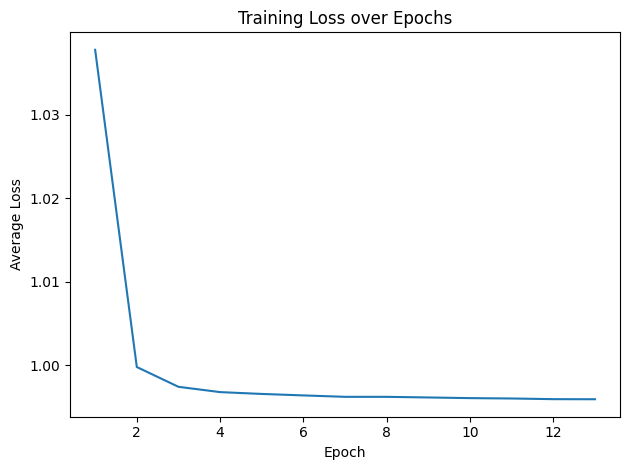

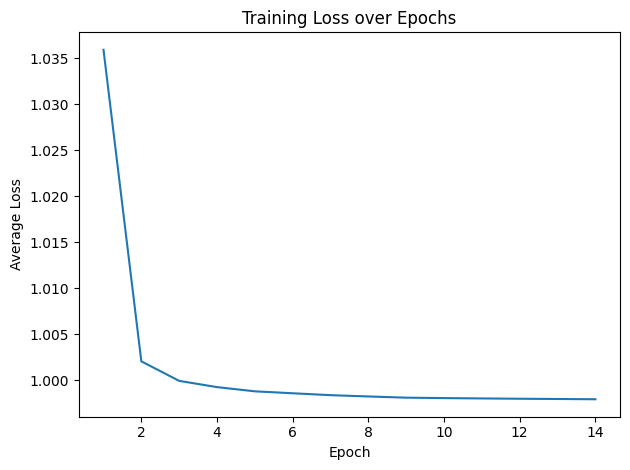

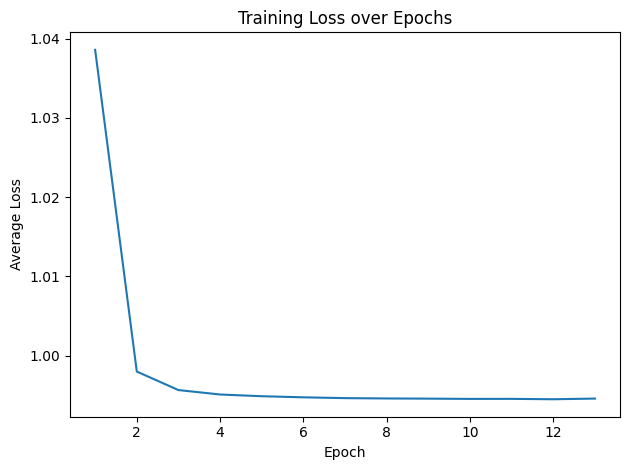

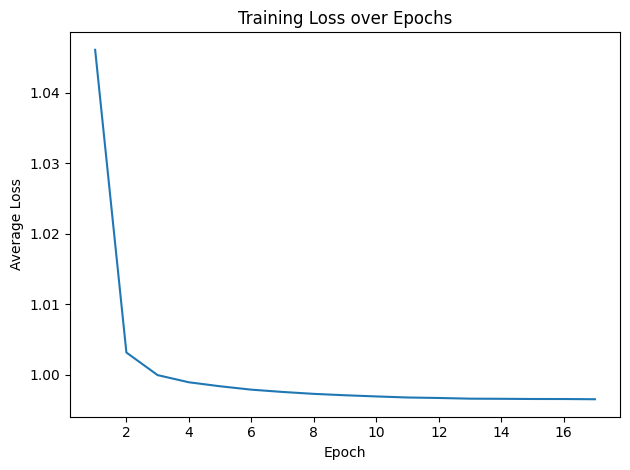

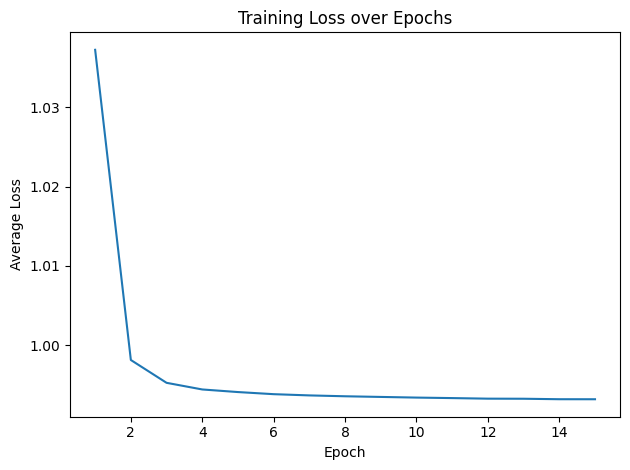

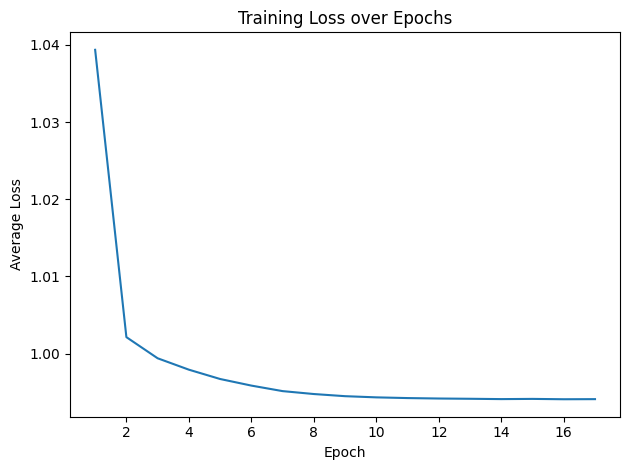

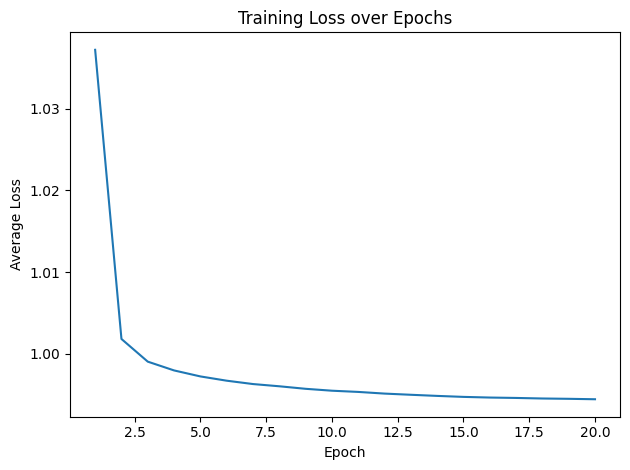

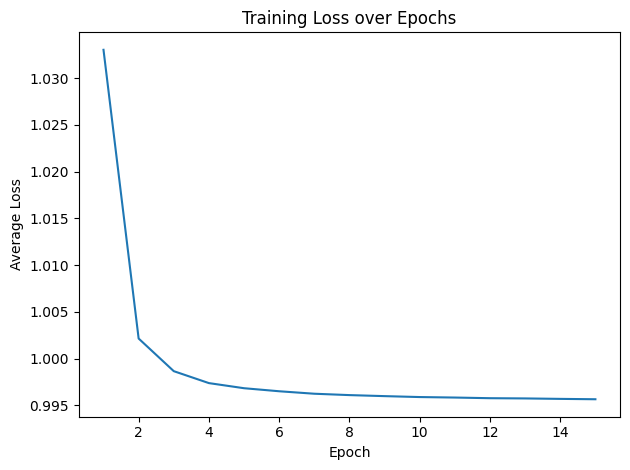

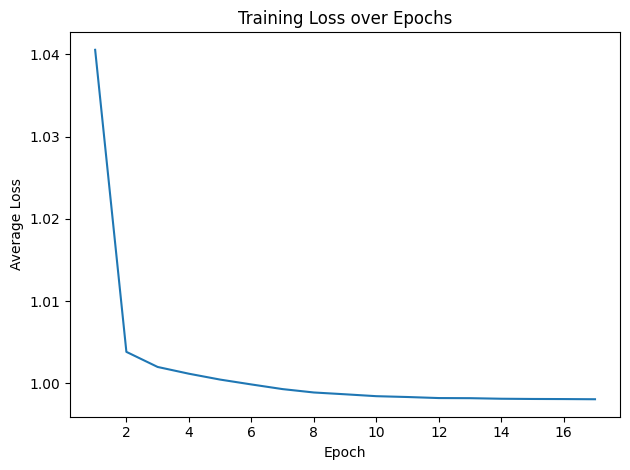

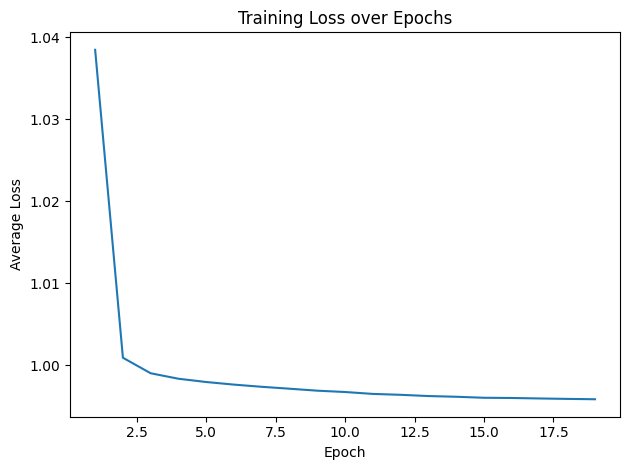

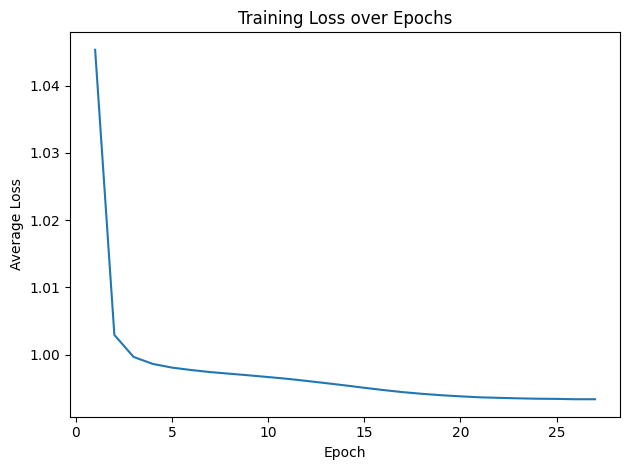

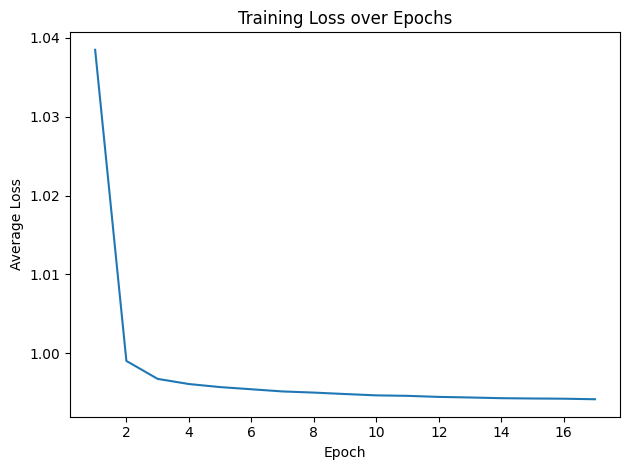

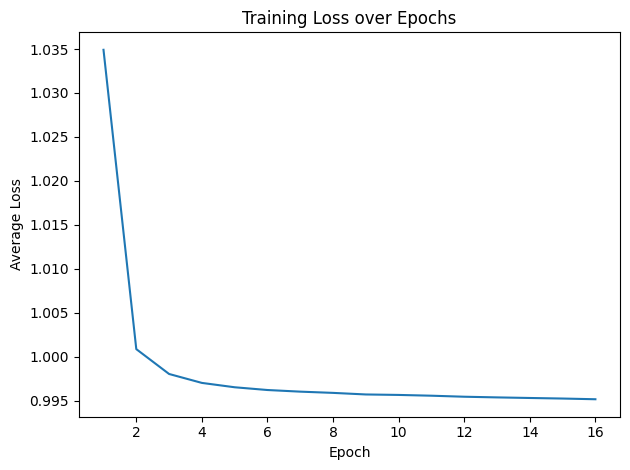

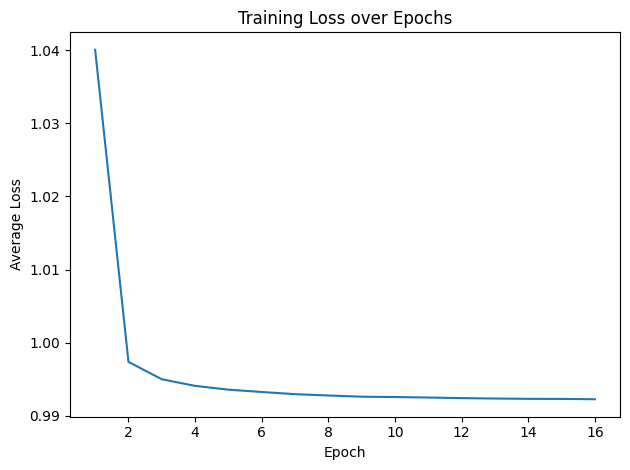

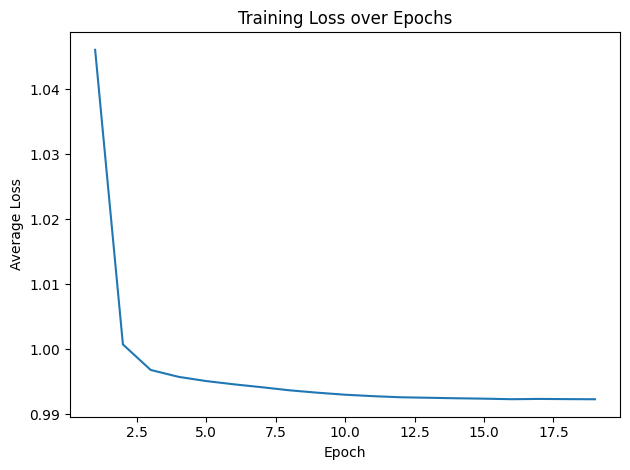

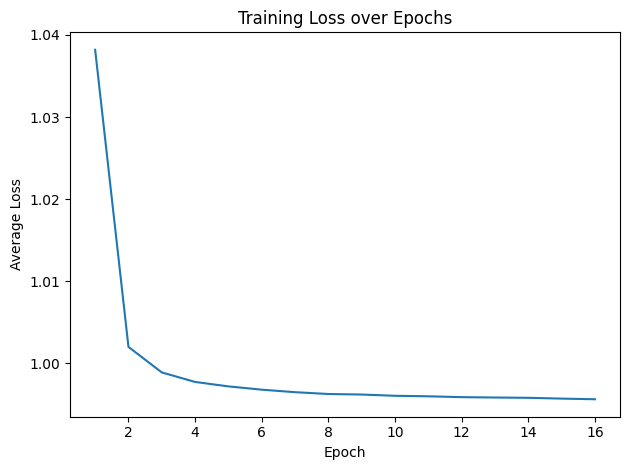

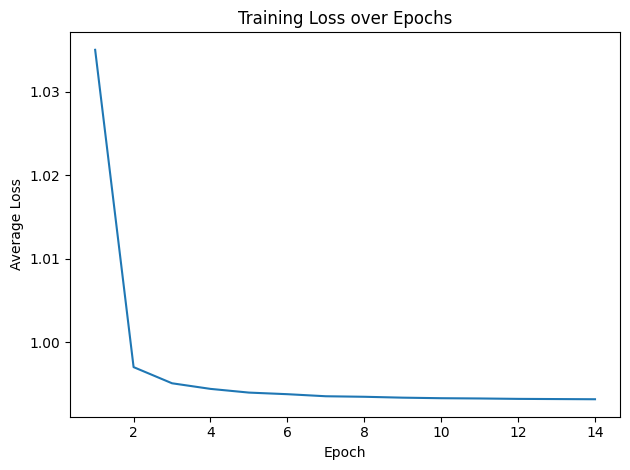

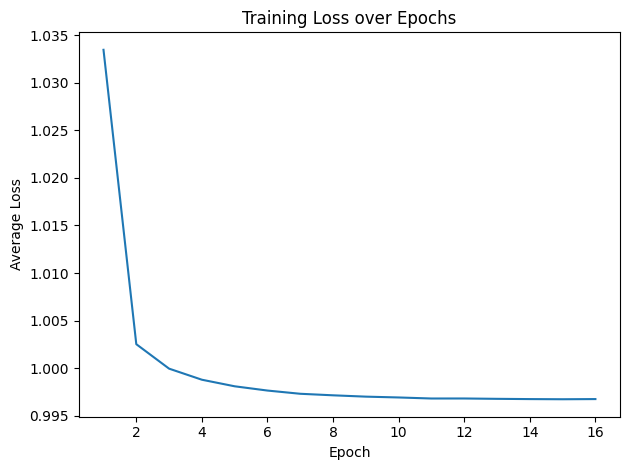

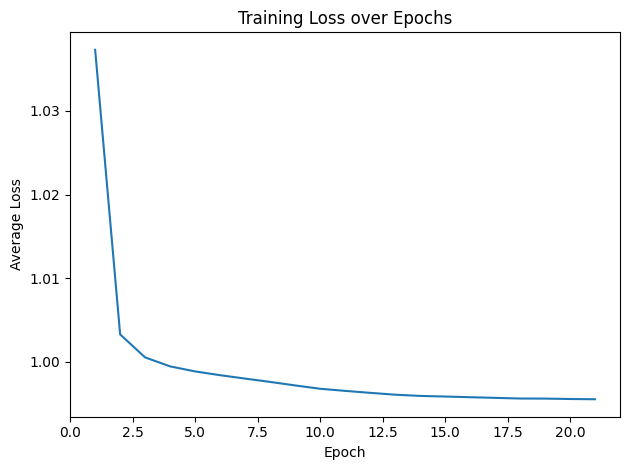

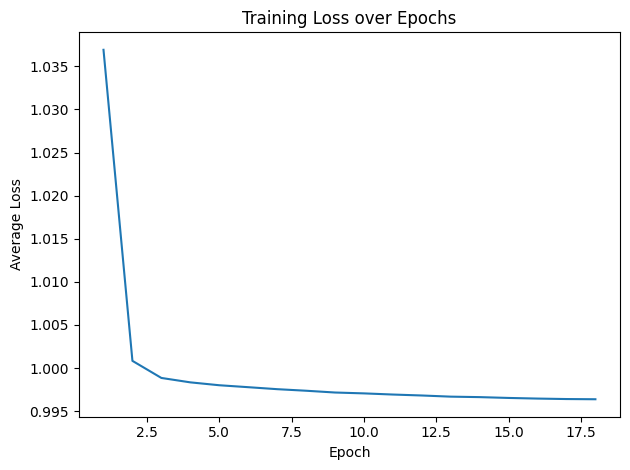

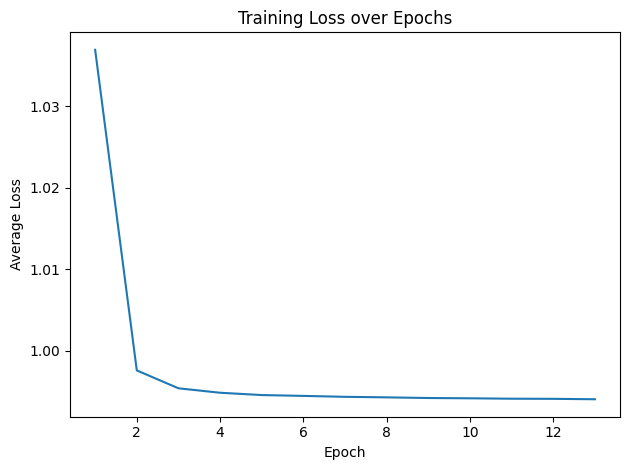

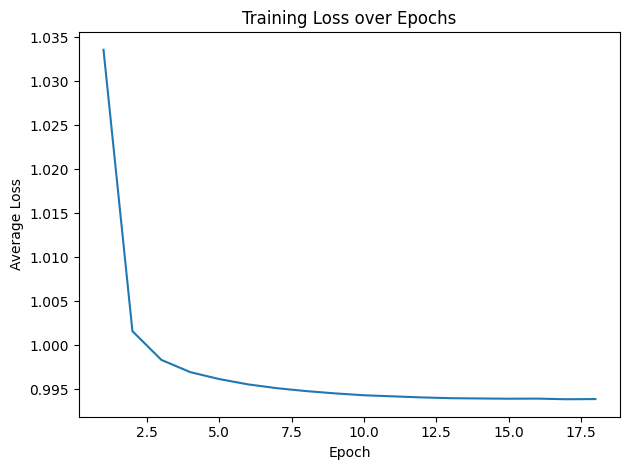

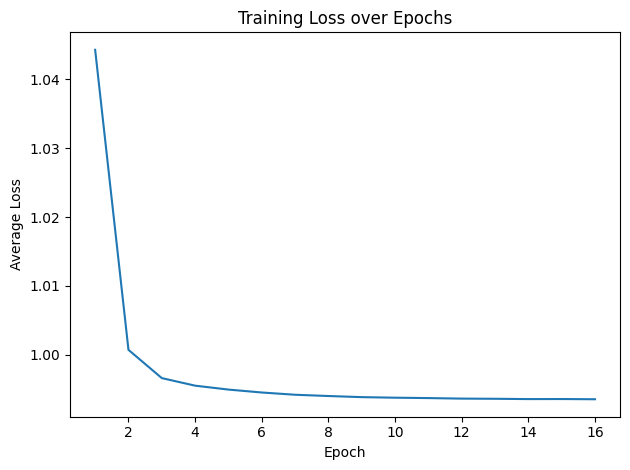

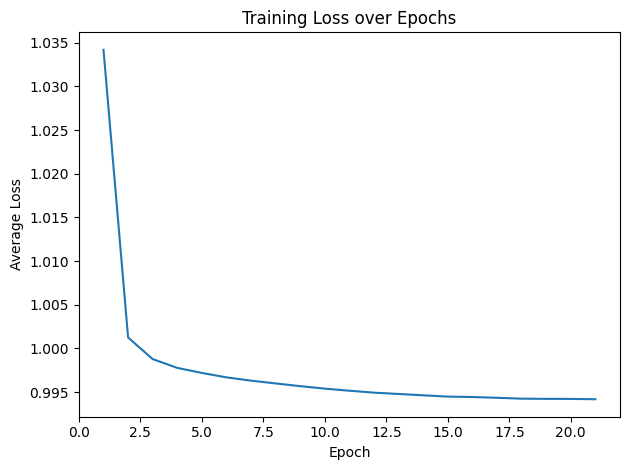

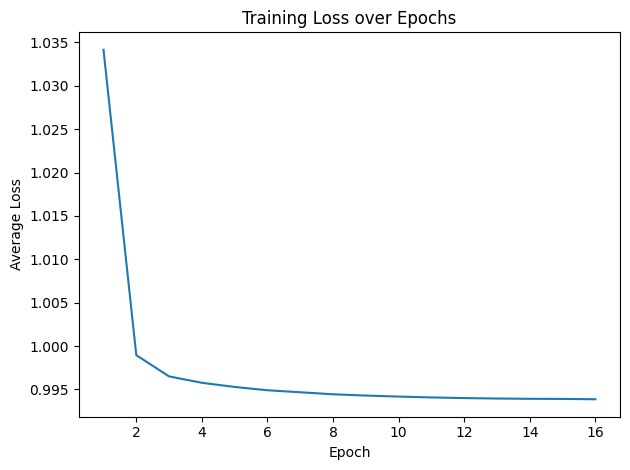

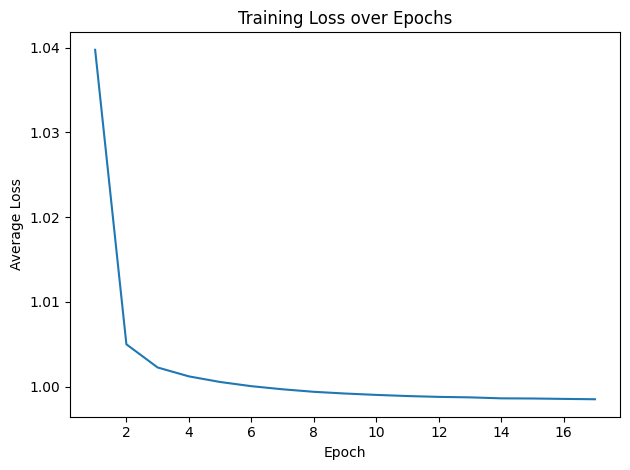

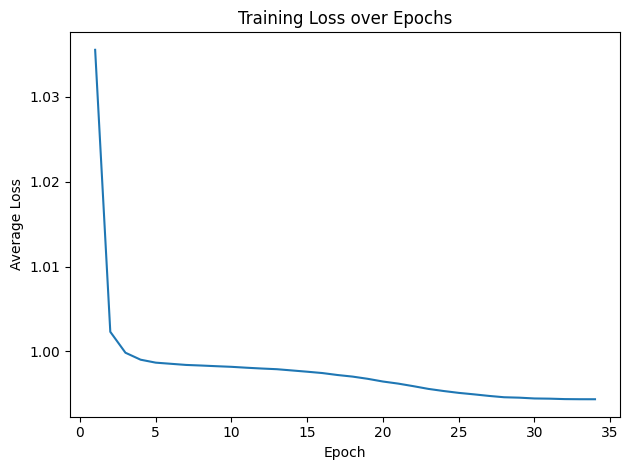

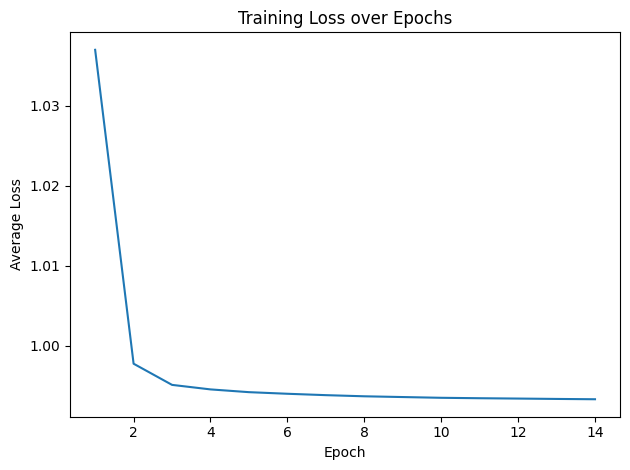

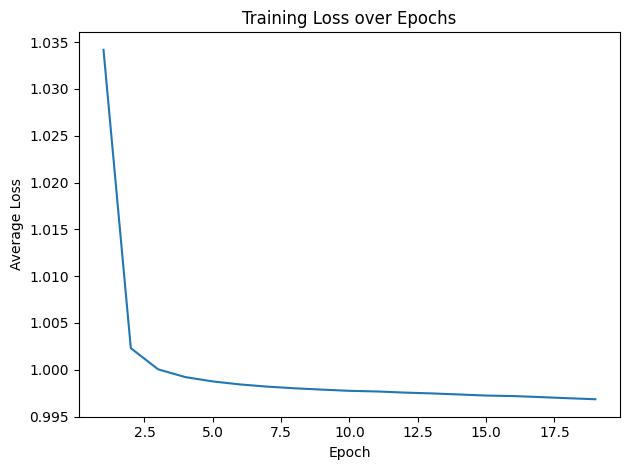

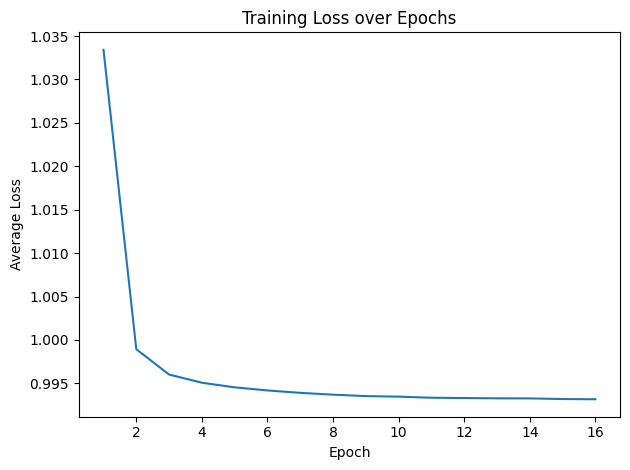

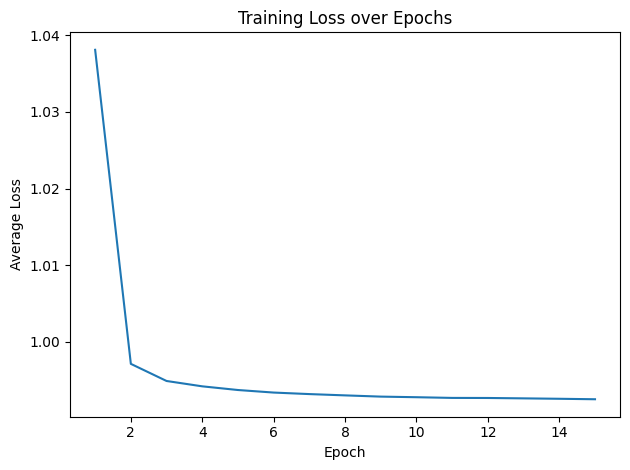

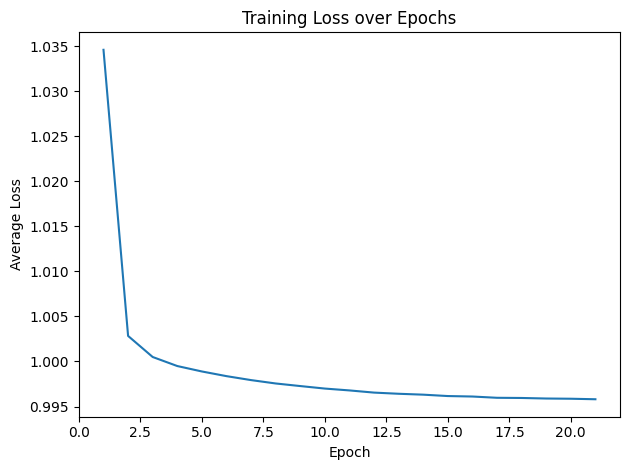

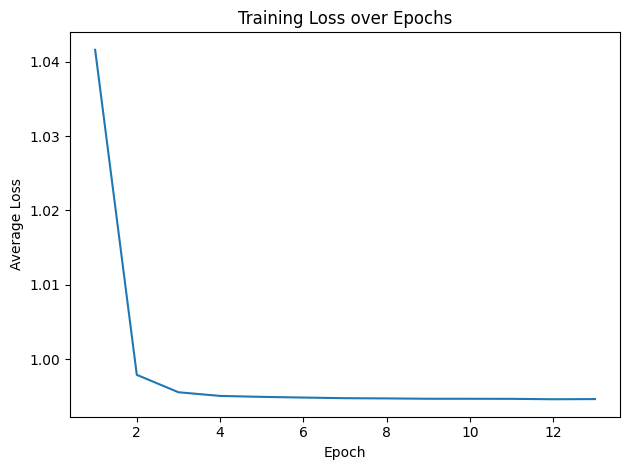

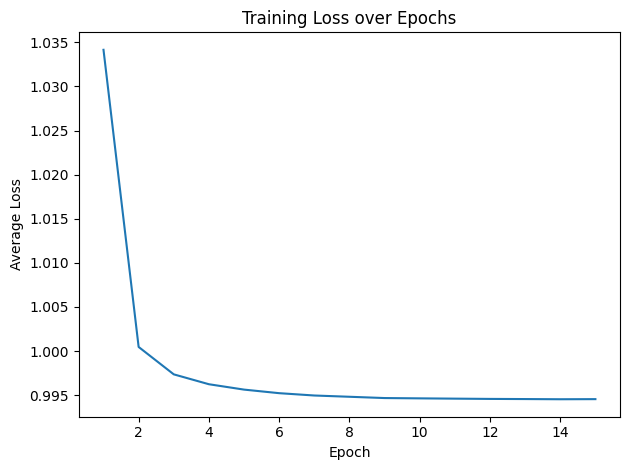

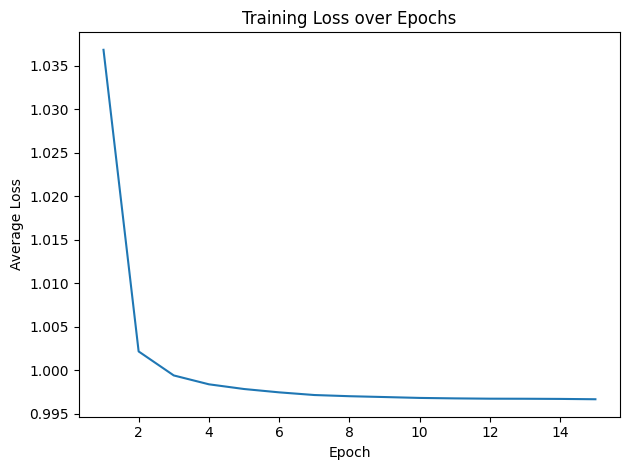

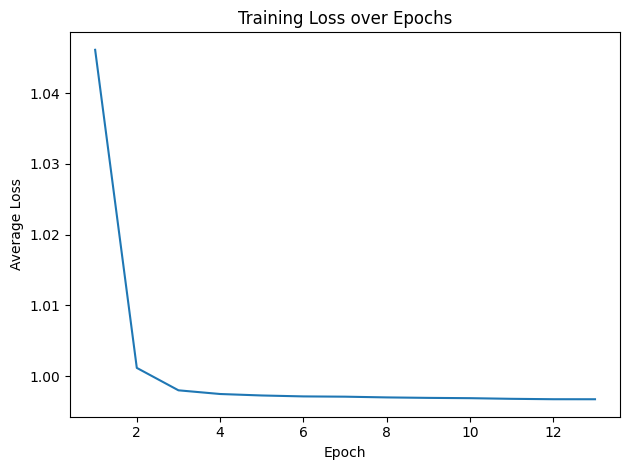

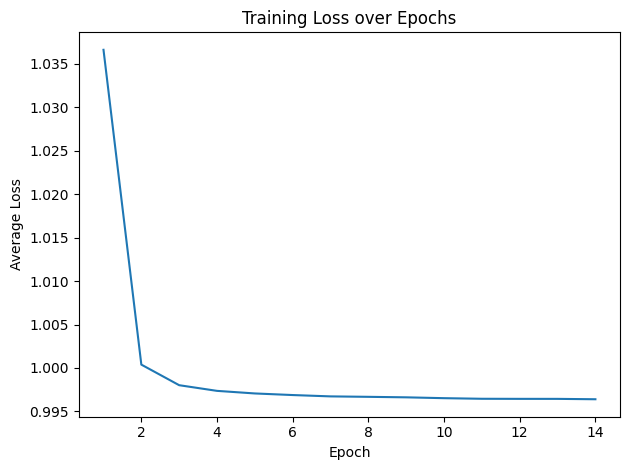

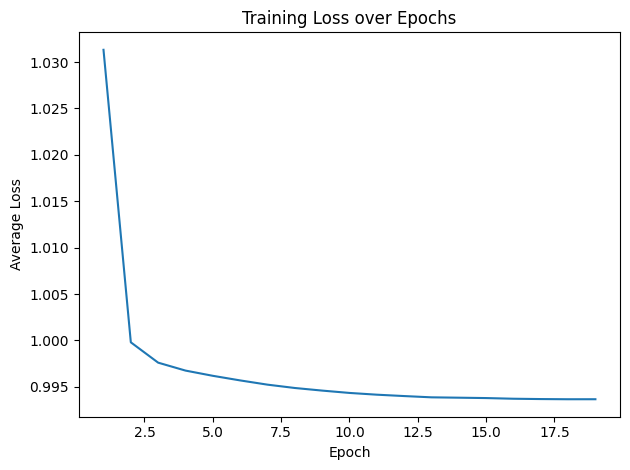

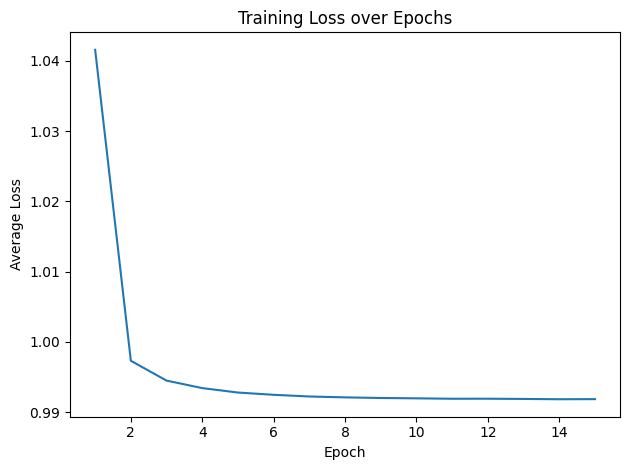

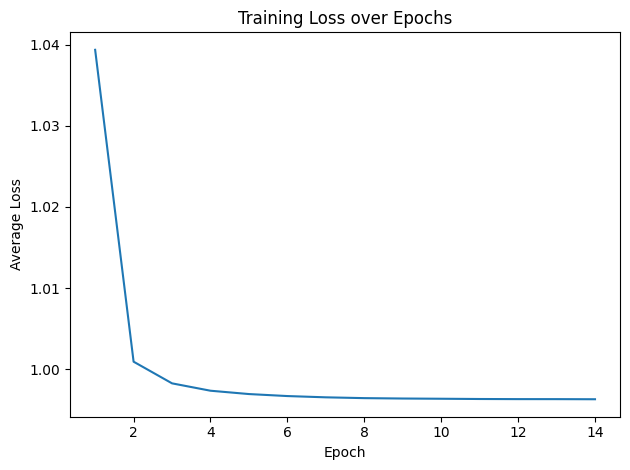

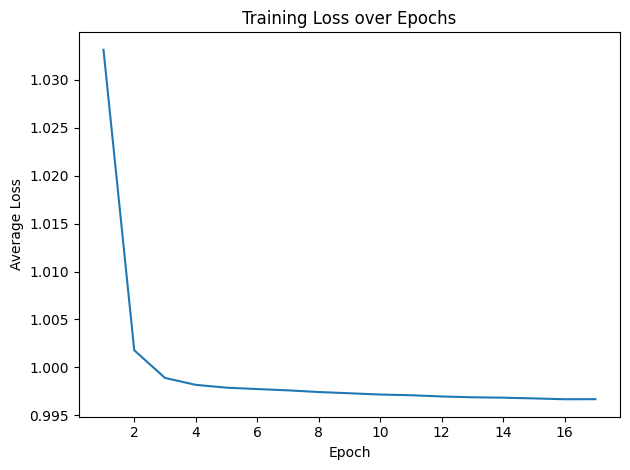

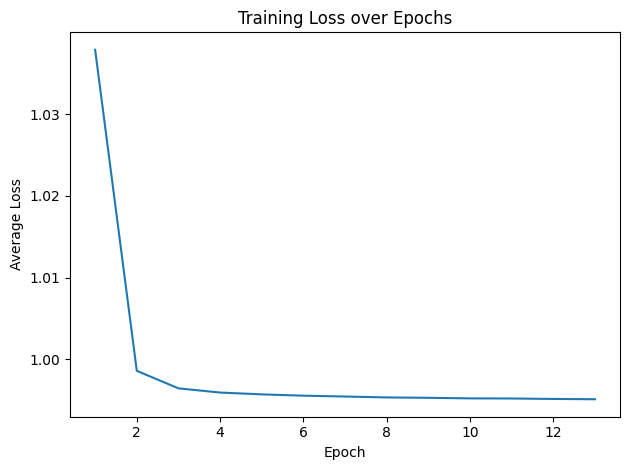

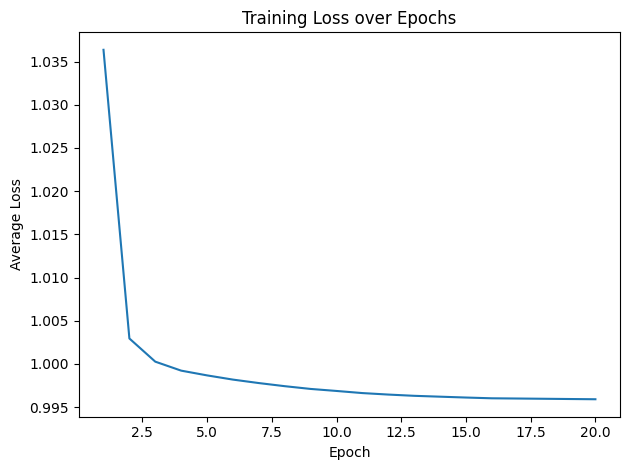

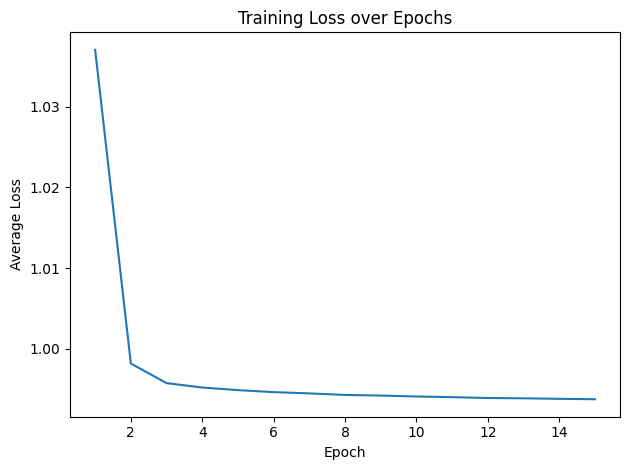

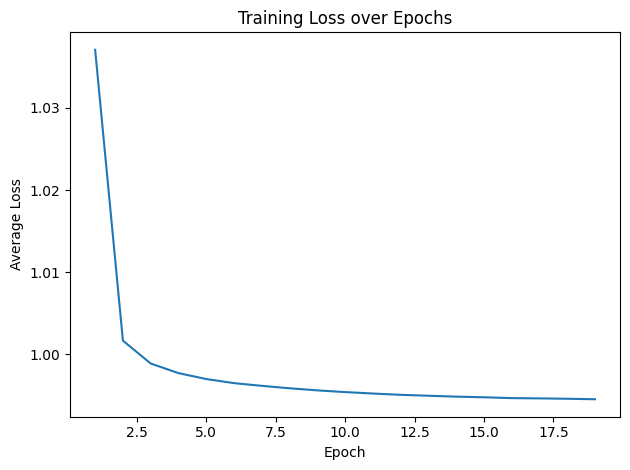

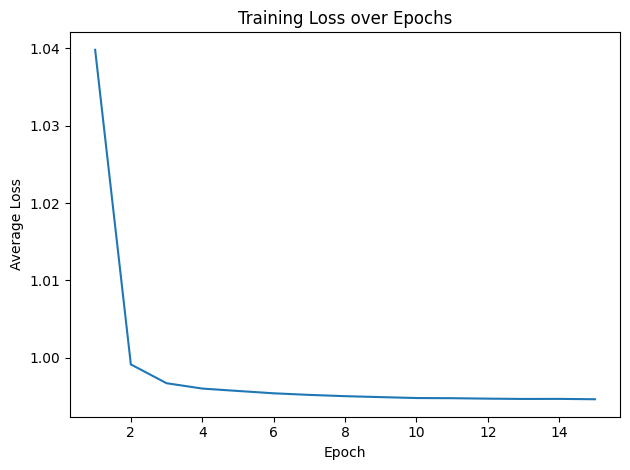

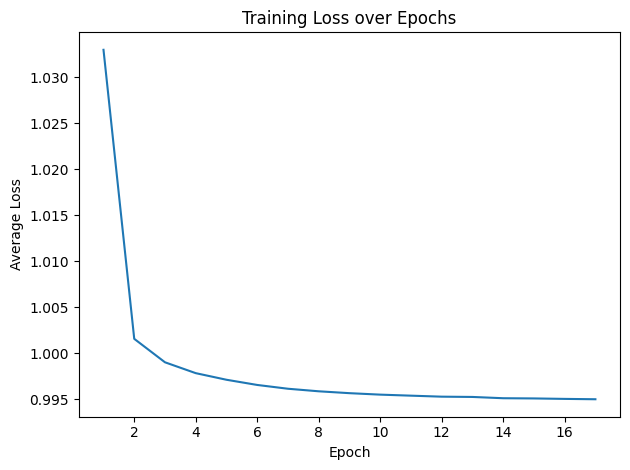

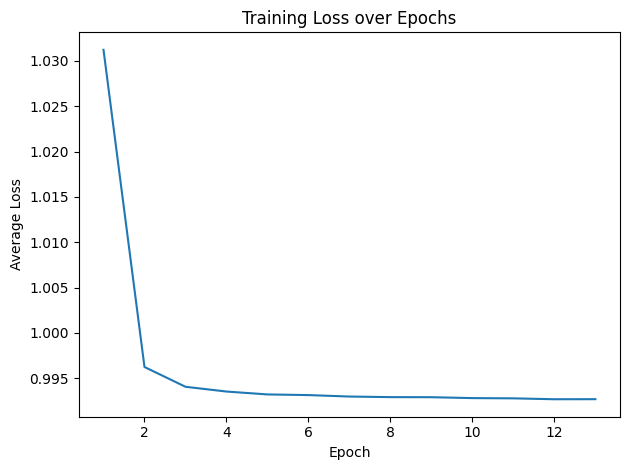

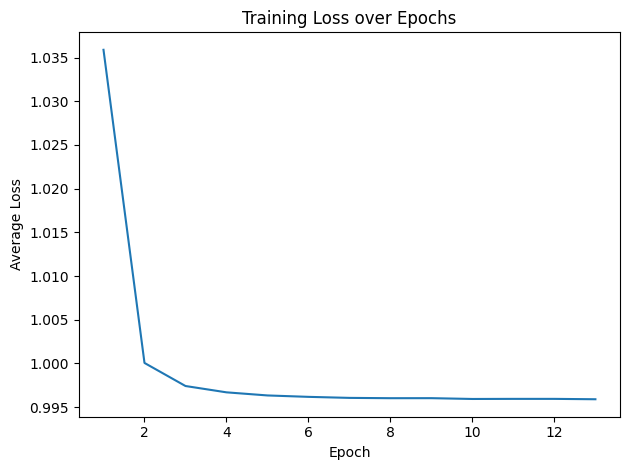

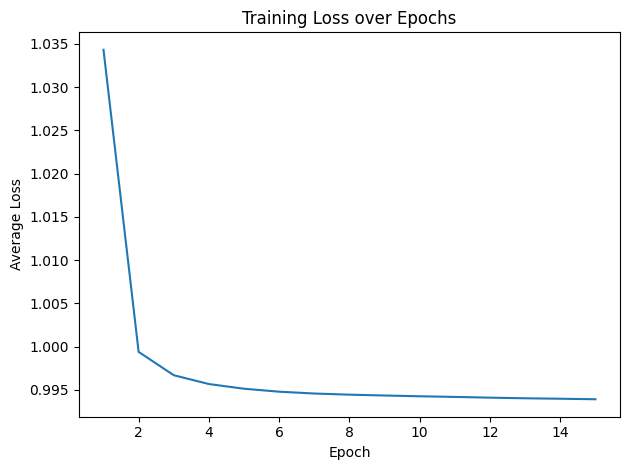

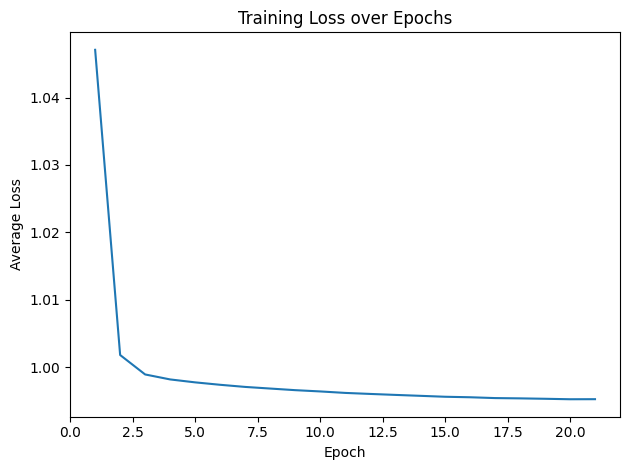

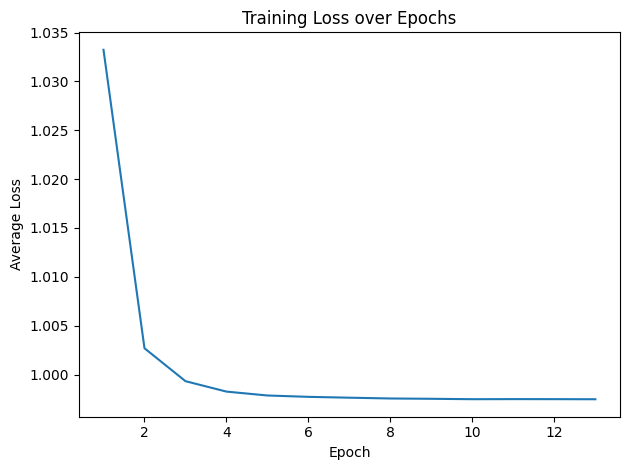

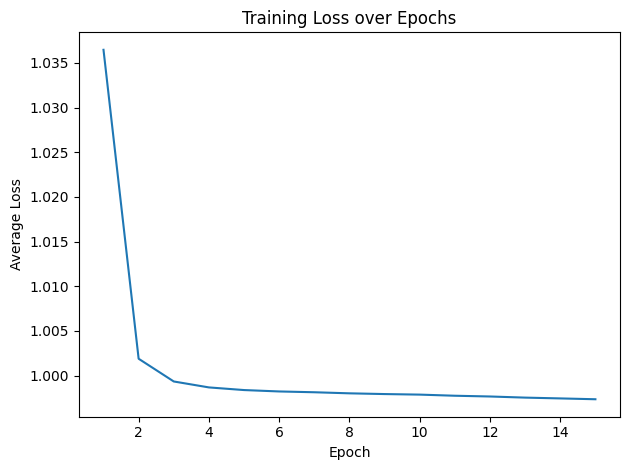

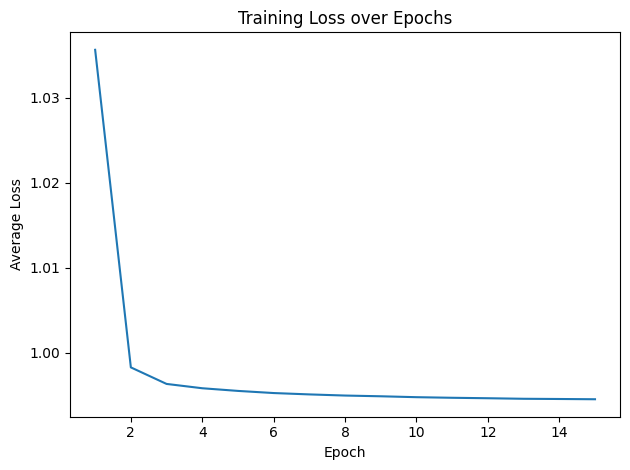

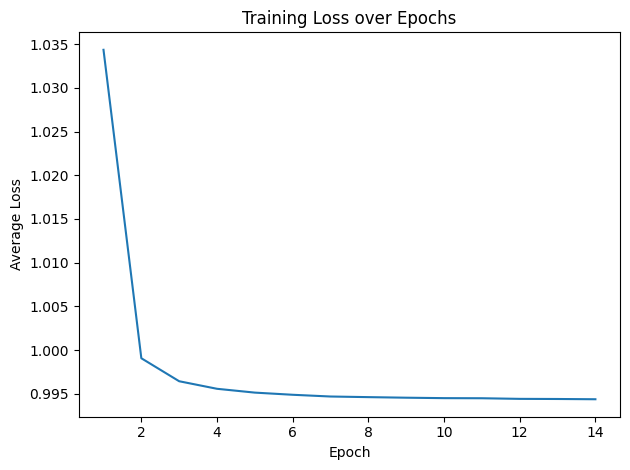

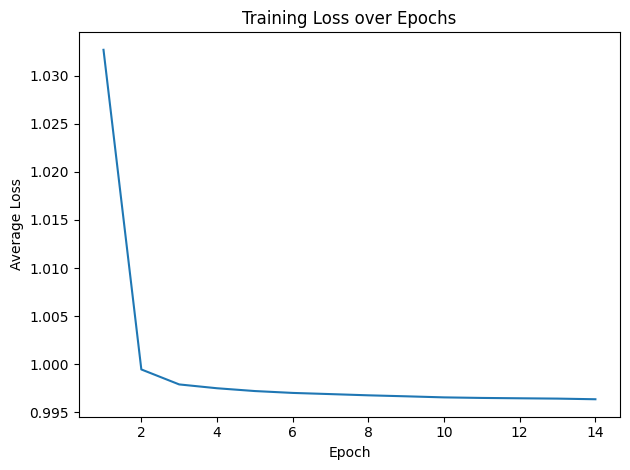

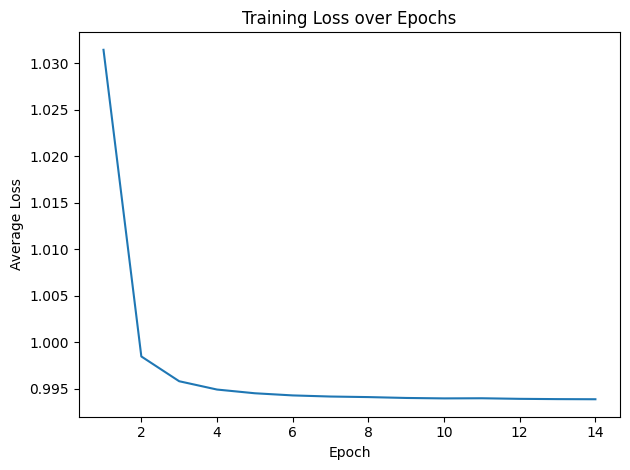

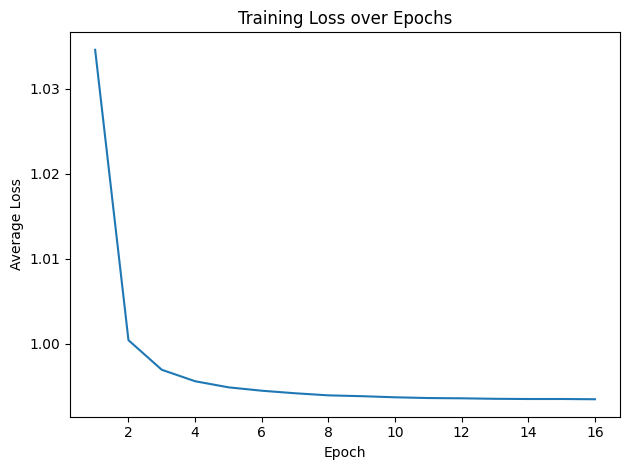

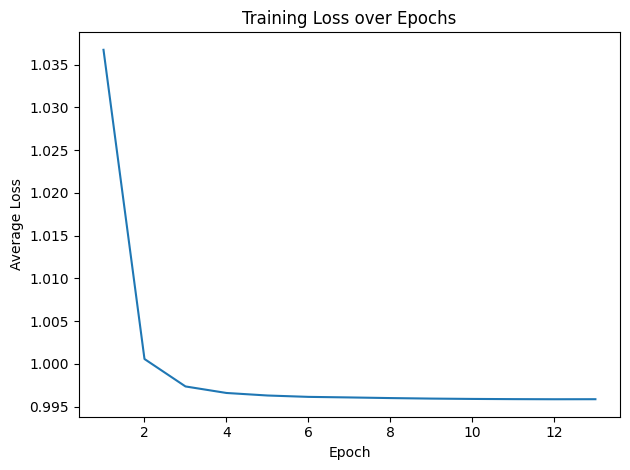

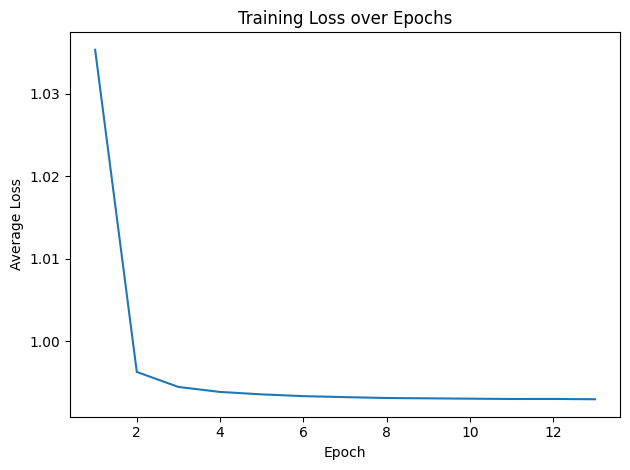

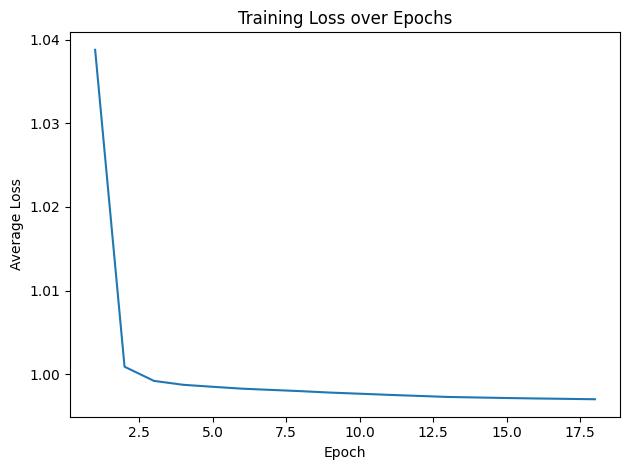

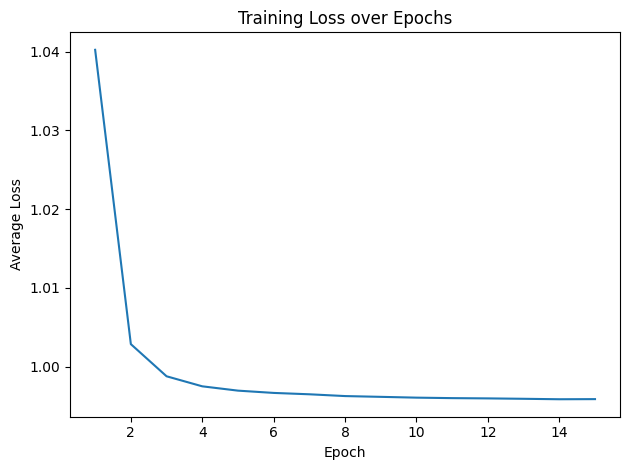

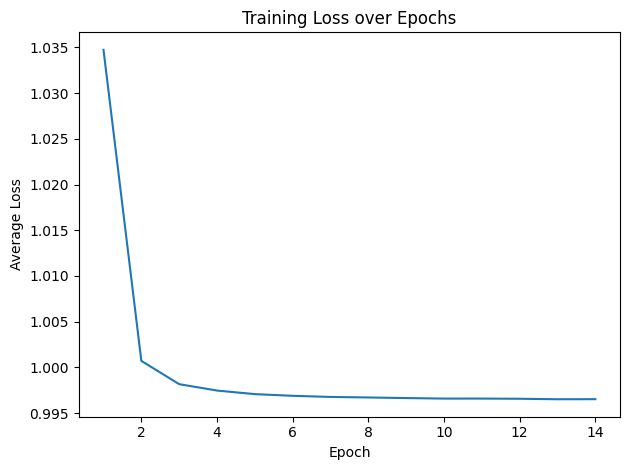

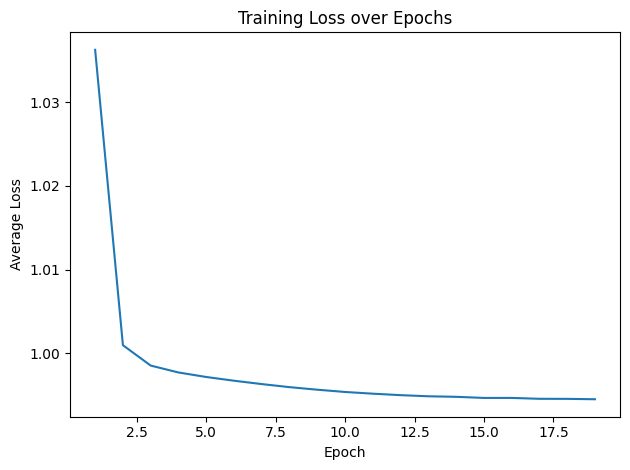

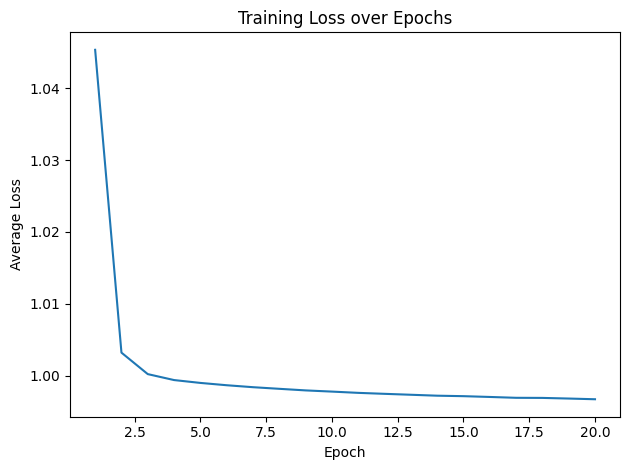

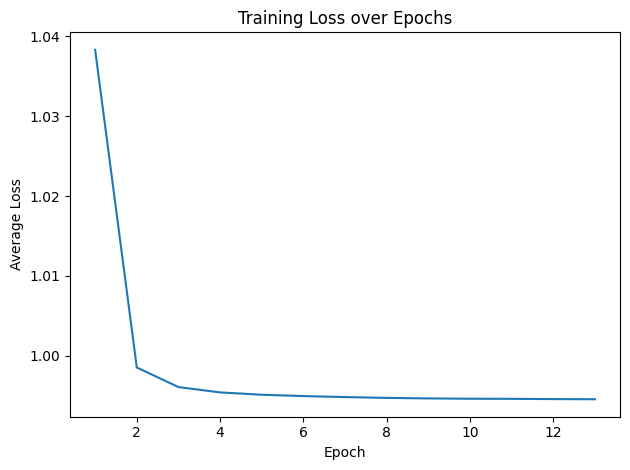

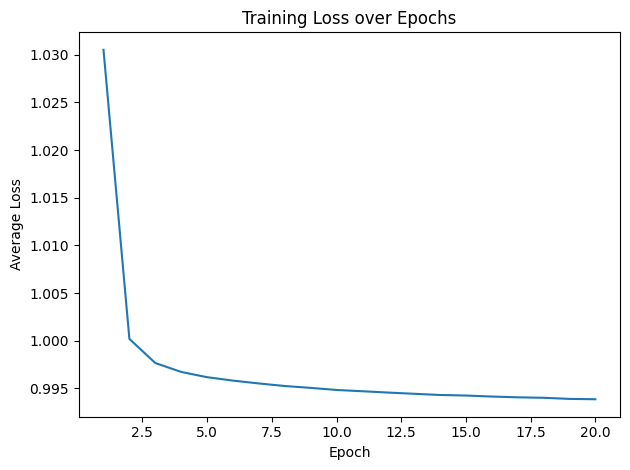

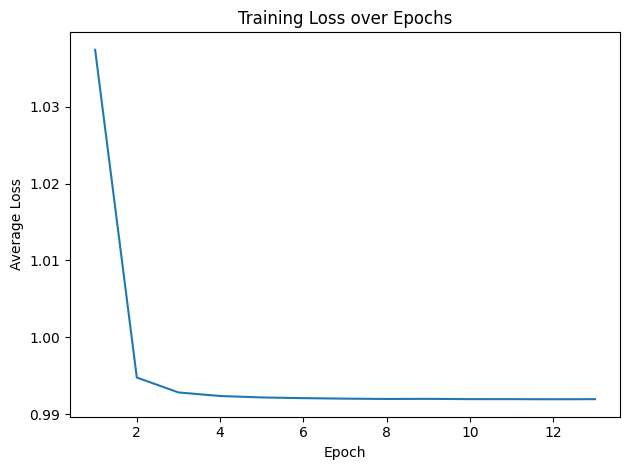

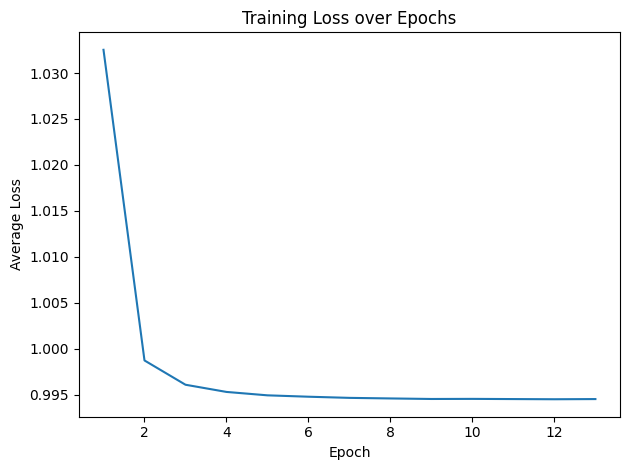

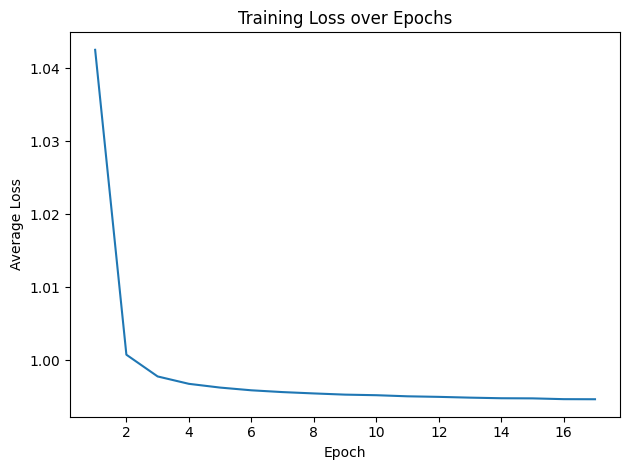

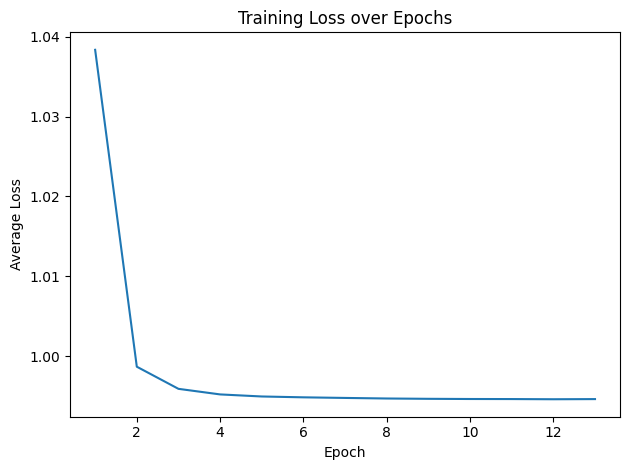

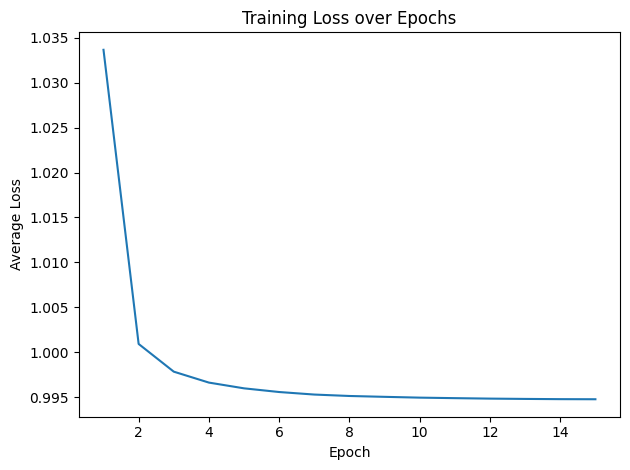

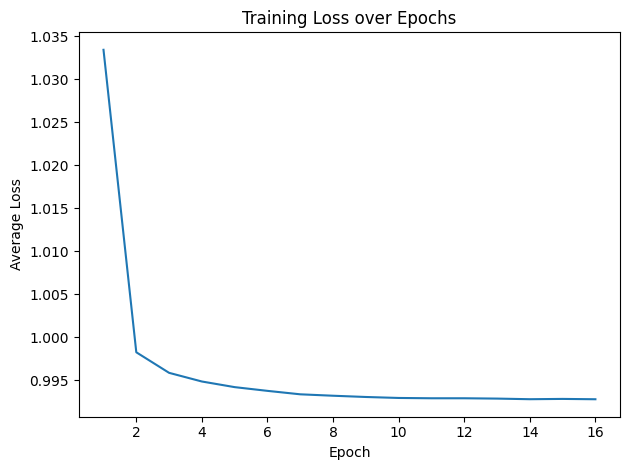

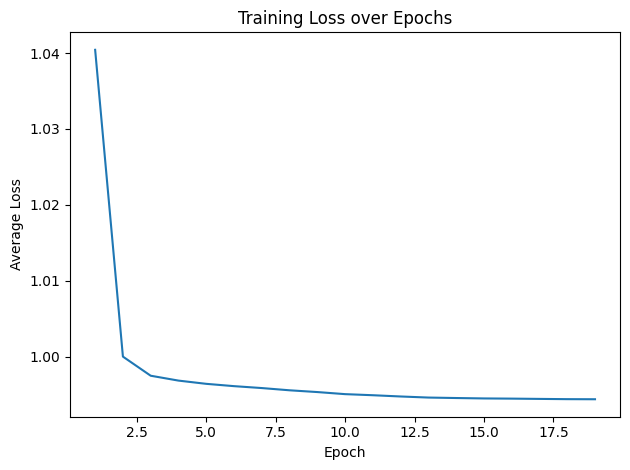

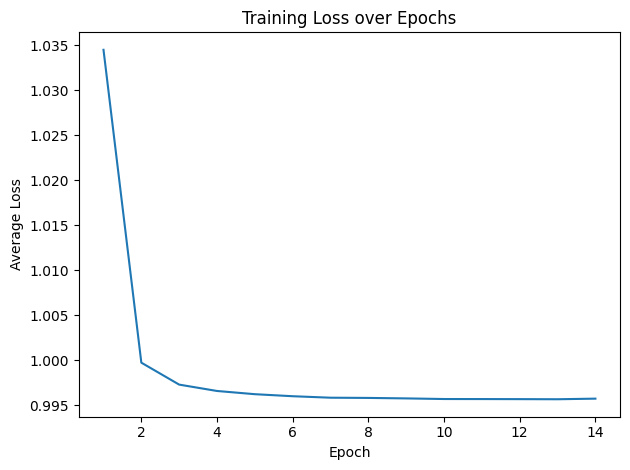

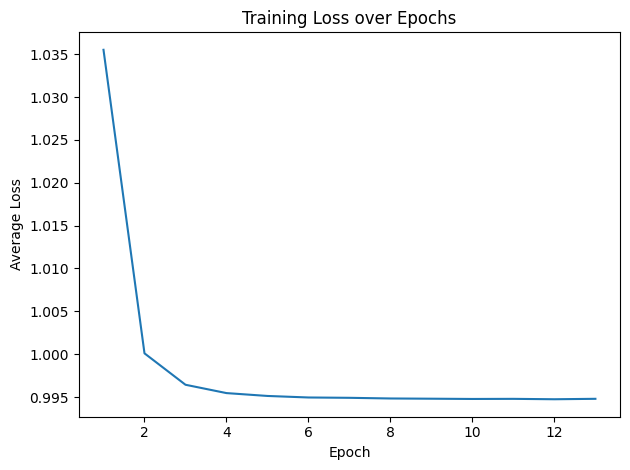

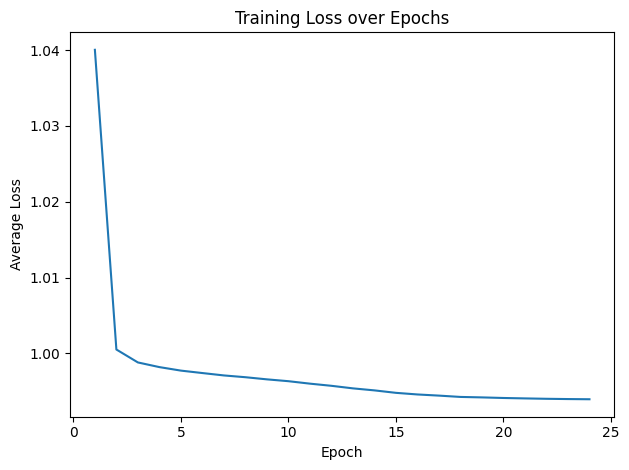

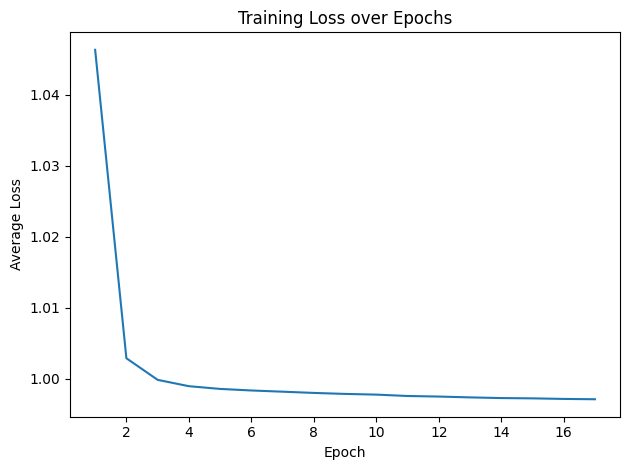

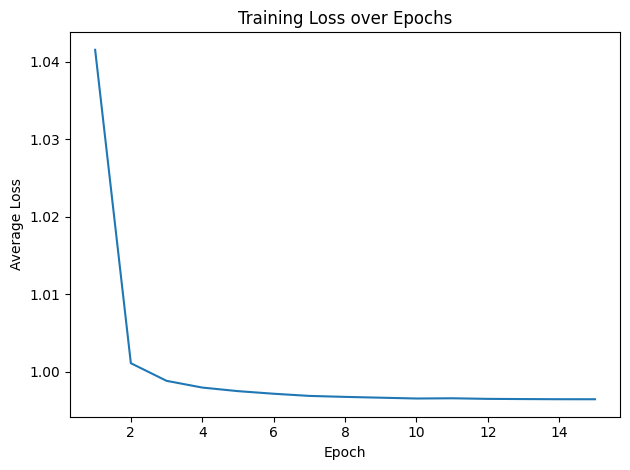

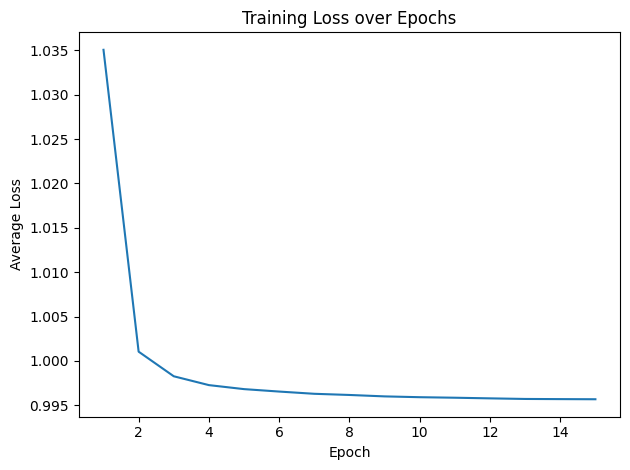

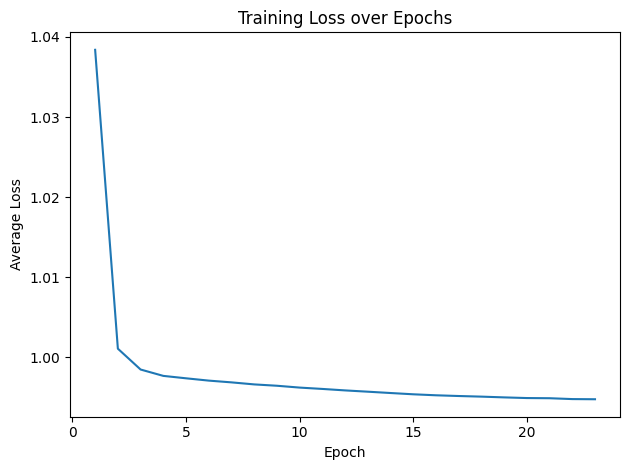

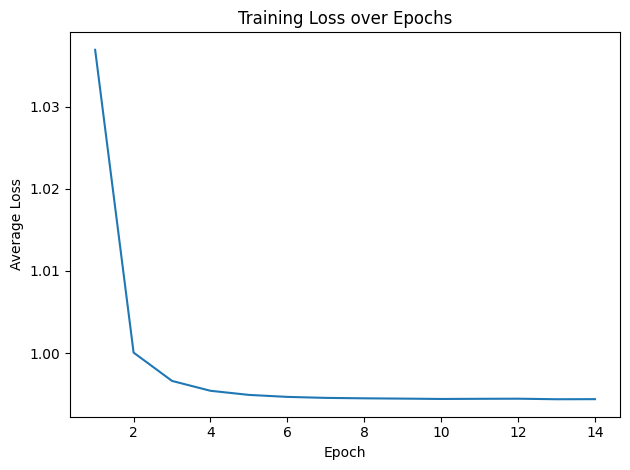

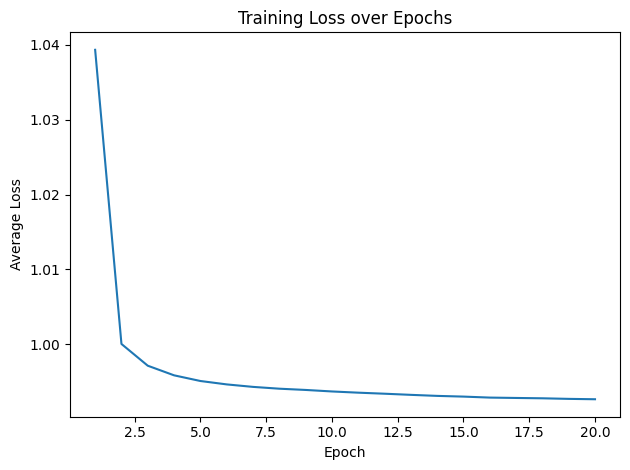

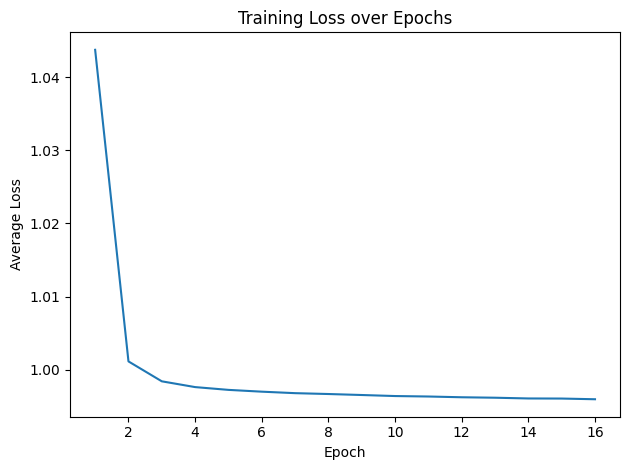

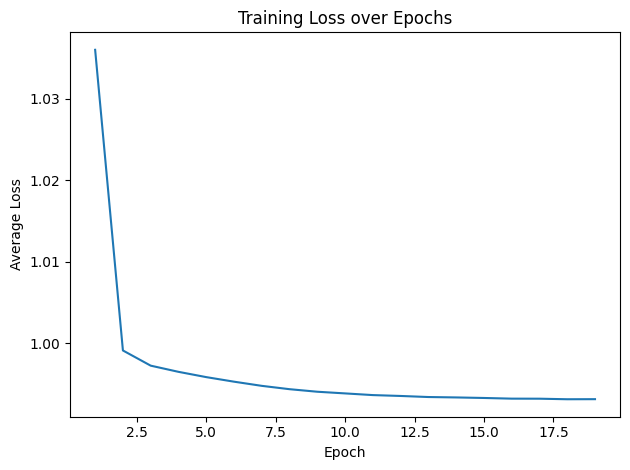

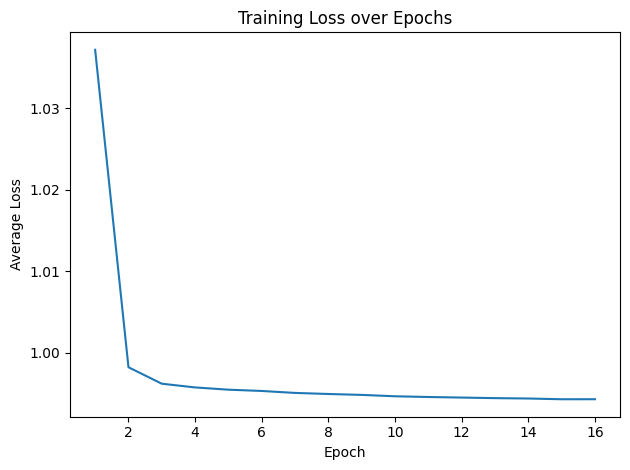

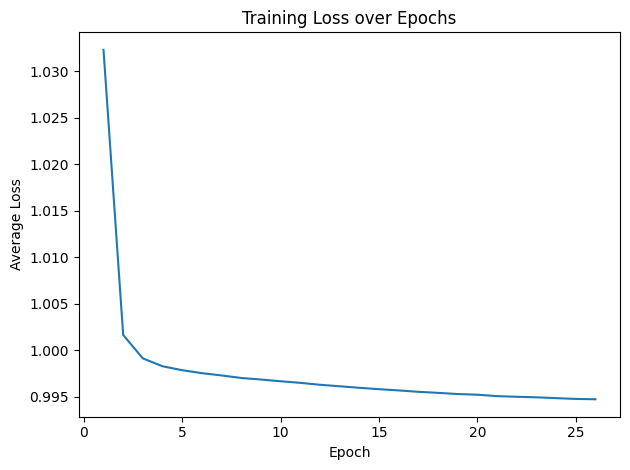

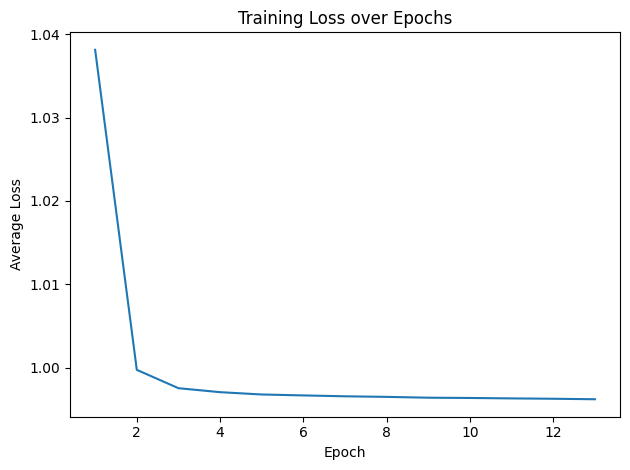

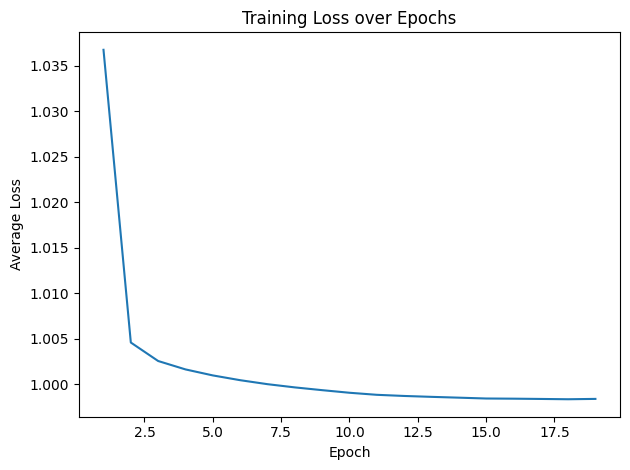

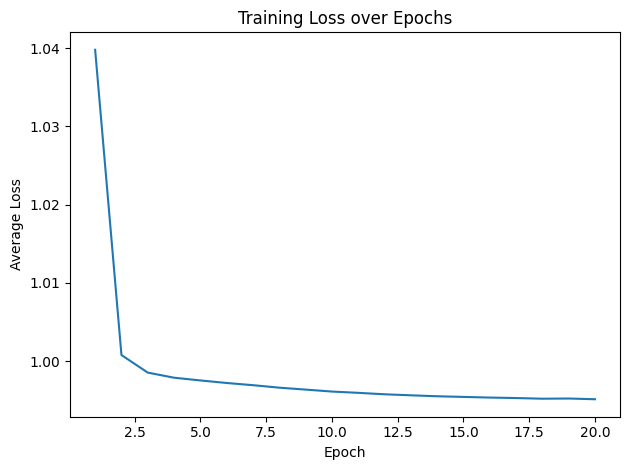

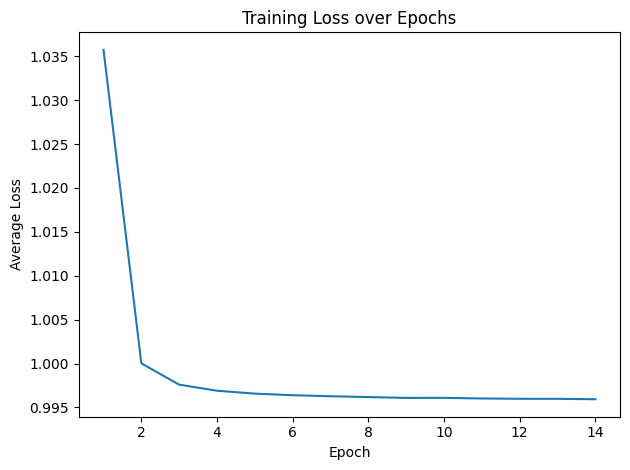

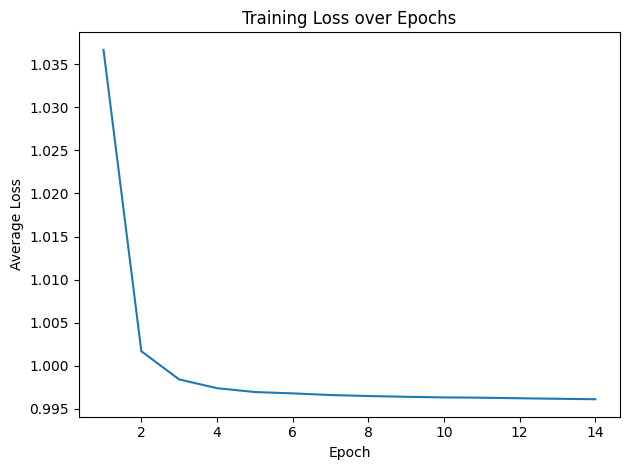

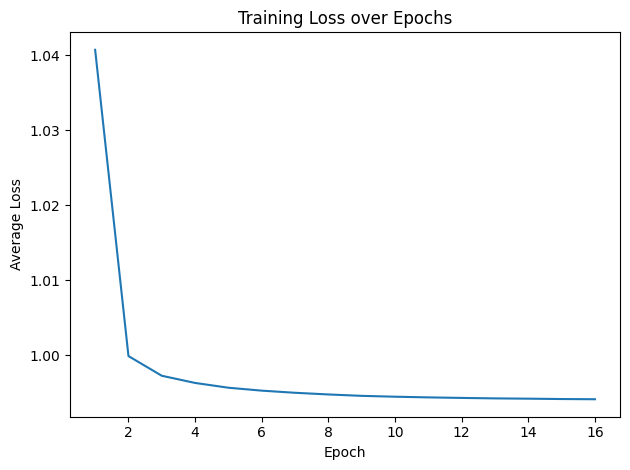

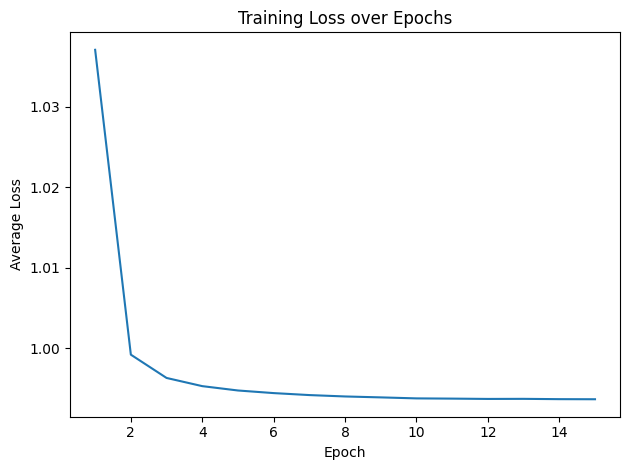

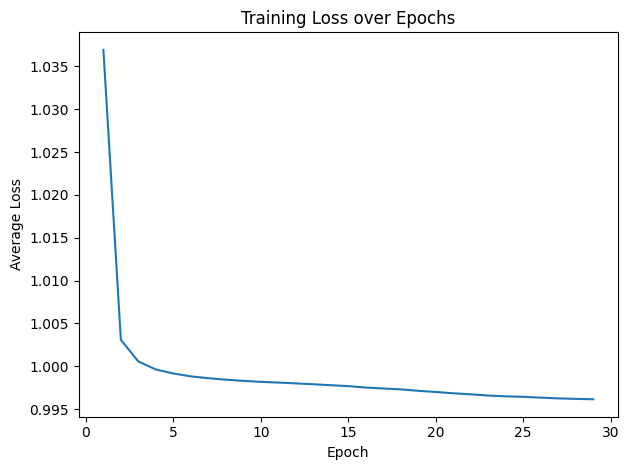

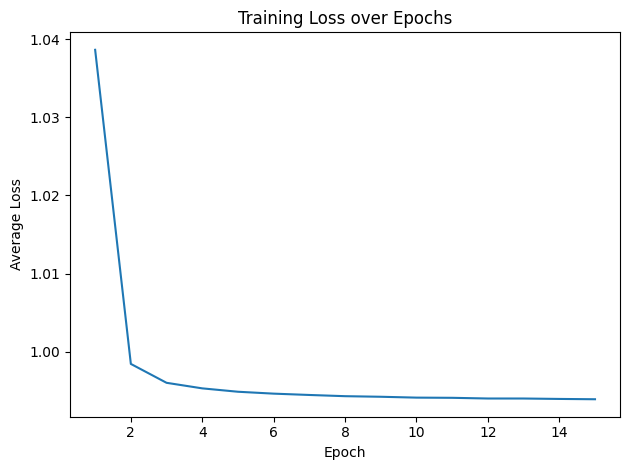

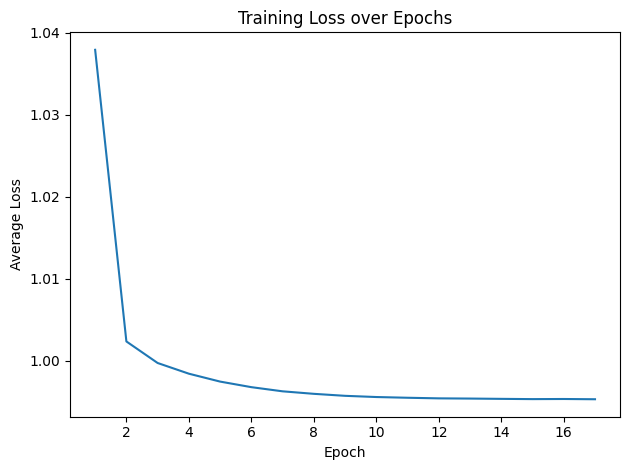

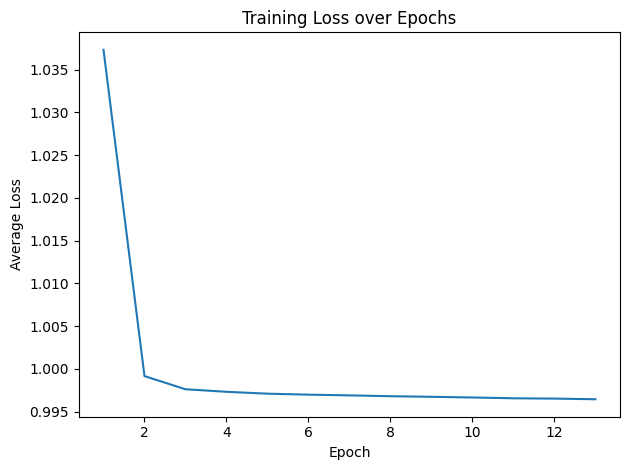

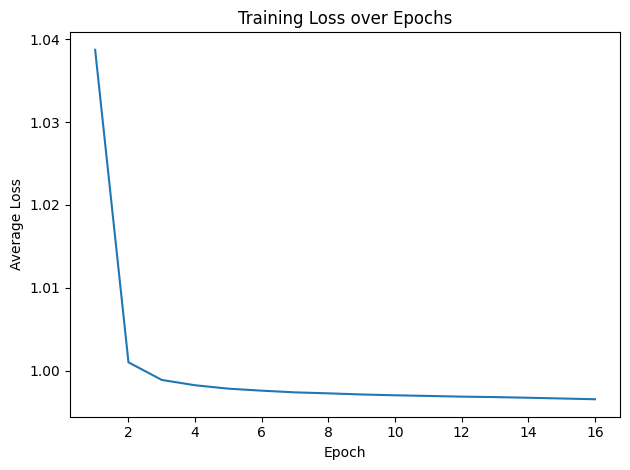

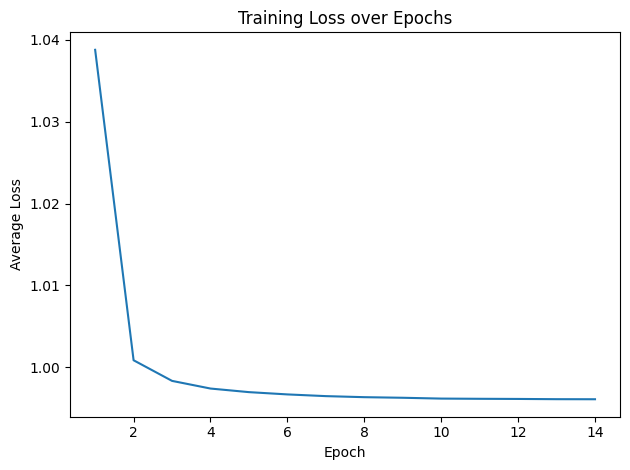

In [72]:
trust_matrices = []

for i in tqdm(range(100)):
    sample = random.choices(comparisons, k=len(comparisons))

    T,t,model = train_trust_matrix(sample)

    trust_matrices.append([T.cpu().numpy().tolist(),
                           t.cpu().numpy().tolist()])

    with open(path + f'bootstrap2/samples.json', "w") as file:
        json.dump(trust_matrices, file, indent=4)
    torch.save(model.state_dict(), path + f'bootstrap2/model_{i}.pt')

In [91]:
import json
import numpy as np
data = []
with open('transcript/20251119_000000/' + f'bootstrap2/samples.json', 'r') as file:
    data.extend(json.load(file))

In [92]:
trust_vectors = np.array([i[1] for i in data])

In [93]:
trust_vectors = [convert_elo(t) for t in trust_vectors]

In [94]:
np.mean(trust_vectors,axis=0)

array([1530.70730766, 1529.89528774, 1482.17413462, 1447.10096131,
       1595.52021032, 1663.59743112, 1484.8046909 , 1465.3769704 ,
       1568.88791136, 1495.8583617 , 1474.00558139, 1519.04418625,
       1439.92497793, 1432.22643055, 1473.67201808, 1496.32007886,
       1451.90432066, 1508.06647615, 1534.28458334, 1582.08548787,
       1484.77702486, 1465.15806366, 1541.92638393, 1541.86081776,
       1421.47472319, 1451.14485818, 1455.86407155, 1439.43386763,
       1422.87079499, 1449.07009991, 1488.9132596 , 1433.93187685,
       1465.04512893, 1455.8934717 , 1532.20880222, 1472.94710536,
       1467.10287237])

In [95]:
variances = np.var(trust_vectors, axis=0, ddof=1)
std_devs = np.sqrt(variances)

print("Std devs of each model's trust score:")
for j, v in enumerate(std_devs, start=1):
    print(f" Model {j:>2}:  {v:.6f}")

Std devs of each model's trust score:
 Model  1:  4.946248
 Model  2:  2.829148
 Model  3:  2.983707
 Model  4:  3.184470
 Model  5:  3.611779
 Model  6:  10.157313
 Model  7:  2.703253
 Model  8:  3.792099
 Model  9:  4.043595
 Model 10:  4.548368
 Model 11:  4.333074
 Model 12:  3.356427
 Model 13:  3.040311
 Model 14:  2.765420
 Model 15:  4.323294
 Model 16:  3.439215
 Model 17:  3.469697
 Model 18:  3.004912
 Model 19:  3.537589
 Model 20:  5.029218
 Model 21:  3.385756
 Model 22:  6.318821
 Model 23:  4.305228
 Model 24:  4.182812
 Model 25:  3.783444
 Model 26:  4.480402
 Model 27:  3.063525
 Model 28:  2.881599
 Model 29:  3.995479
 Model 30:  3.108885
 Model 31:  3.234215
 Model 32:  3.955336
 Model 33:  6.712706
 Model 34:  3.072990
 Model 35:  3.651294
 Model 36:  2.806710
 Model 37:  3.551797


In [96]:
lower_bounds = np.percentile(trust_vectors, 2.5, axis=0)
upper_bounds = np.percentile(trust_vectors, 97.5, axis=0)

# Combine into intervals
cis = list(zip(lower_bounds, upper_bounds))

for j, (lo, hi) in enumerate(cis, start=1):
    print(f"Model {j:>2} 95% CI: [{lo:.4f}, {hi:.4f}]")
    # lo_ = int(1500 + (400/np.log(10)) * np.log(5 * lo))
    # hi_ = int(1500 + (400/np.log(10)) * np.log(5 * hi))
    # print(f"Model {j:>2} 95% CI: [{lo_:.4f}, {hi_:.4f}]")

Model  1 95% CI: [1523.7588, 1542.6780]
Model  2 95% CI: [1524.8060, 1534.6618]
Model  3 95% CI: [1476.2075, 1487.2038]
Model  4 95% CI: [1441.8426, 1453.2740]
Model  5 95% CI: [1589.9056, 1603.1071]
Model  6 95% CI: [1646.9156, 1683.9166]
Model  7 95% CI: [1479.6368, 1489.1682]
Model  8 95% CI: [1458.0597, 1472.4943]
Model  9 95% CI: [1561.5811, 1576.1042]
Model 10 95% CI: [1486.9769, 1504.0616]
Model 11 95% CI: [1466.3915, 1483.9857]
Model 12 95% CI: [1511.8076, 1524.4228]
Model 13 95% CI: [1433.8248, 1446.2761]
Model 14 95% CI: [1426.4527, 1436.9940]
Model 15 95% CI: [1466.9575, 1482.9576]
Model 16 95% CI: [1489.6756, 1502.5700]
Model 17 95% CI: [1445.2451, 1457.7464]
Model 18 95% CI: [1502.1133, 1513.2765]
Model 19 95% CI: [1527.5287, 1541.3827]
Model 20 95% CI: [1572.9265, 1591.4124]
Model 21 95% CI: [1479.1337, 1491.0980]
Model 22 95% CI: [1452.5455, 1474.5383]
Model 23 95% CI: [1534.5011, 1550.3023]
Model 24 95% CI: [1533.5673, 1549.3512]
Model 25 95% CI: [1414.7118, 1428.5032]


In [97]:
lower_bounds, upper_bounds

(array([1523.75877919, 1524.80601796, 1476.20746644, 1441.84264287,
        1589.90561704, 1646.91561238, 1479.63682623, 1458.0597079 ,
        1561.58106928, 1486.97694659, 1466.39151431, 1511.80761238,
        1433.82480998, 1426.45268661, 1466.95752693, 1489.67560571,
        1445.24505583, 1502.1132723 , 1527.52869213, 1572.9264769 ,
        1479.1337099 , 1452.54552888, 1534.50109181, 1533.56725609,
        1414.71184391, 1441.0816101 , 1451.11762074, 1434.09380903,
        1416.31790429, 1443.71737051, 1482.20657462, 1427.10338461,
        1455.79606728, 1450.29496533, 1524.63015159, 1468.20587356,
        1460.20619336]),
 array([1542.67804862, 1534.66179919, 1487.20377217, 1453.27396446,
        1603.10711104, 1683.9166032 , 1489.16820489, 1472.49429701,
        1576.1042116 , 1504.0616225 , 1483.98568744, 1524.42275401,
        1446.2761459 , 1436.99396305, 1482.95763554, 1502.56997719,
        1457.74638989, 1513.2764765 , 1541.38266133, 1591.41235516,
        1491.09800754, 

In [106]:
scores = [0.0317, 0.0322, 0.0242, 0.0200, 0.0468, 0.0708, 0.0245, 0.0224, 0.0398, 0.0266, 0.0229, 0.0301, 0.0190, 0.0182, 0.0227, 0.0265, 0.0200, 0.0287, 0.0333, 0.0448, 0.0246, 0.0226, 0.0349, 0.0344, 0.0173, 0.0202, 0.0210, 0.0188, 0.0170, 0.0200, 0.0253, 0.0182, 0.0215, 0.0209, 0.0328, 0.0229, 0.0222]
scores = convert_elo(np.array(scores))

model_names = ['Claude 4.5 Sonnet',
  'Claude 4.0 Sonnet',
  'Claude 3.7 Sonnet',
  'Claude 3.5 Sonnet',
  'GPT 5.1',
  'GPT 5',
  'GPT 4.1',
  'GPT 4o',
  'GPT oss 120b',
  'GPT oss 20b',
  'Gemini 3 Pro Preview',
  'Gemini 2.5 Pro',
  'Gemini 2.0 Flash',
  'Grok 4.1 Fast',
  'Grok 4',
  'Grok 3',
  'DeepSeek v3',
  'DeepSeek R1T Chimera',
  'Qwen 3 235B',
  'Qwen 3 80b',
  'Qwen 3 32b',
  'Qwen 2.5 72b',
  'Kimi K2 thinking',
  'Kimi K2 0711',
  'Mistral Nemo',
  'Mistral Small 3.2',
  'Mistral Tiny',
  'Cydonia 24B V4.1',
  'Llama 4 Maverick',
  'Llama 4 Scout',
  'Llama 3.3 70b',
  'Nvidia Nemotron Nano',
  'Nvidia Nemotron Nano 12B',
  'Microsoft Phi 4',
  'GLM 4.6',
  'GLM 4.5 Air',
  'Baidu Ernie 4.5']

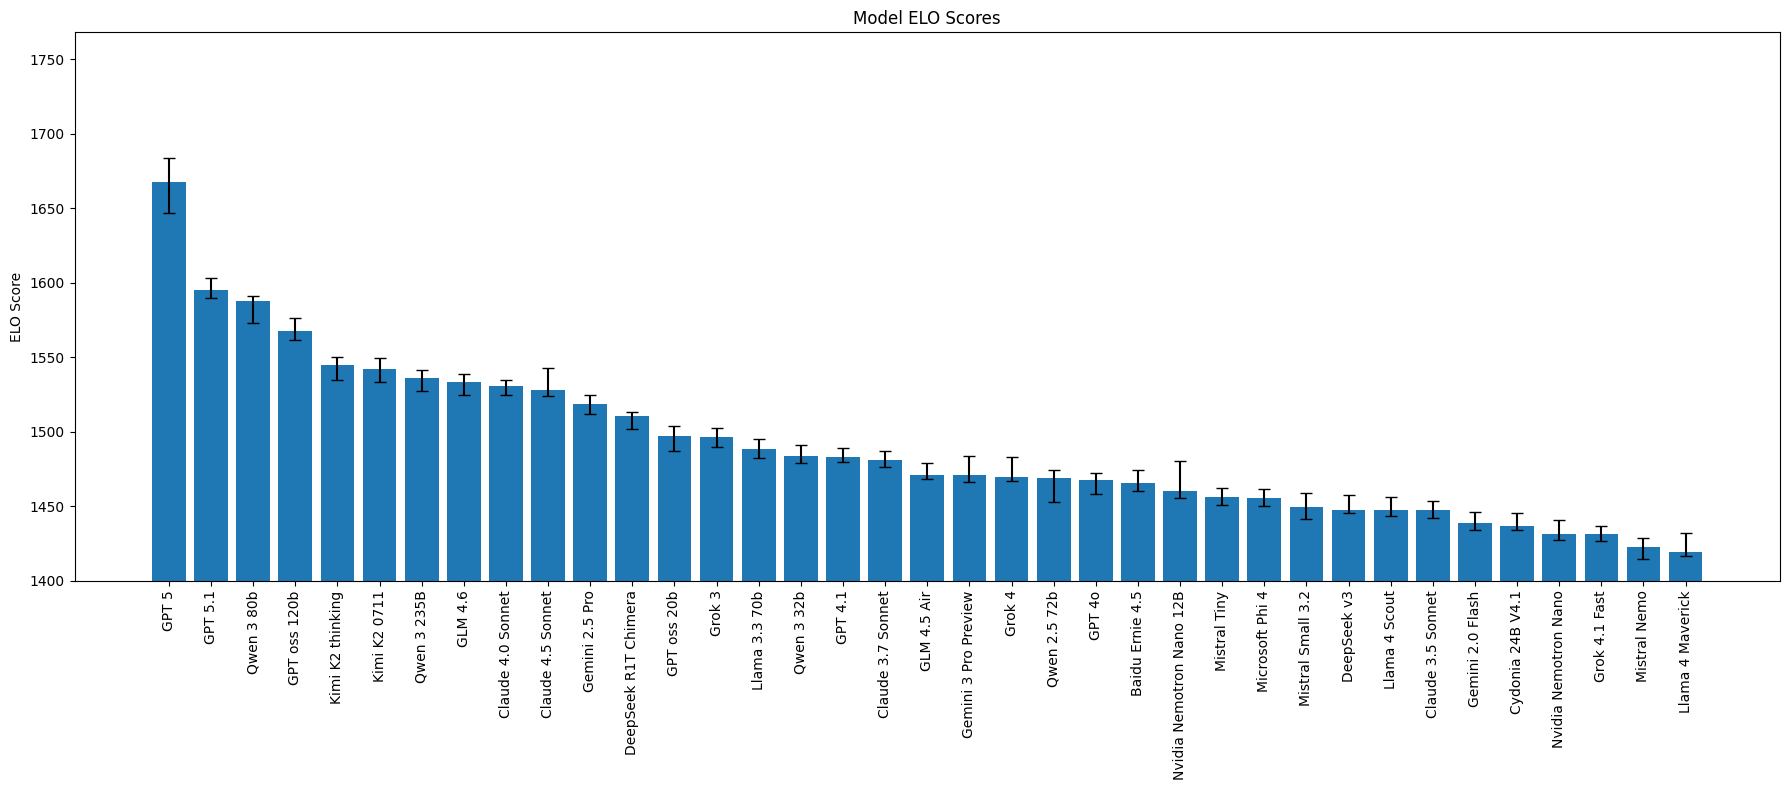

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to arrays
scores = np.array(scores)
lb = np.array(lower_bounds)
ub = np.array(upper_bounds)
names = np.array(model_names)

# ---- Sort in descending order of score ----
idx = np.argsort(scores)[::-1]
scores = scores[idx]
lb = lb[idx]
ub = ub[idx]
names = names[idx]

# ---- Error bars (asymmetric) ----
lower_err = scores - lb
upper_err = ub - scores

for j,val in enumerate(lower_err):
    if val < 0:
        lower_err[j] = 0
        print('lower err negative for model', names[j])
for j,val in enumerate(upper_err):
    if val < 0:
        upper_err[j] = 0
        print('upper err negative for model', names[j])

yerr = np.vstack([lower_err, upper_err])

# ---- Plot ----
x = np.arange(len(names))
plt.figure(figsize=(18, 8))

plt.bar(x, scores, yerr=yerr, capsize=4)
plt.xticks(x, names, rotation=90)
plt.ylabel("ELO Score")
plt.title("Model ELO Scores")

# Set y-axis lower bound
plt.ylim(1400, None)

plt.tight_layout()
plt.show()


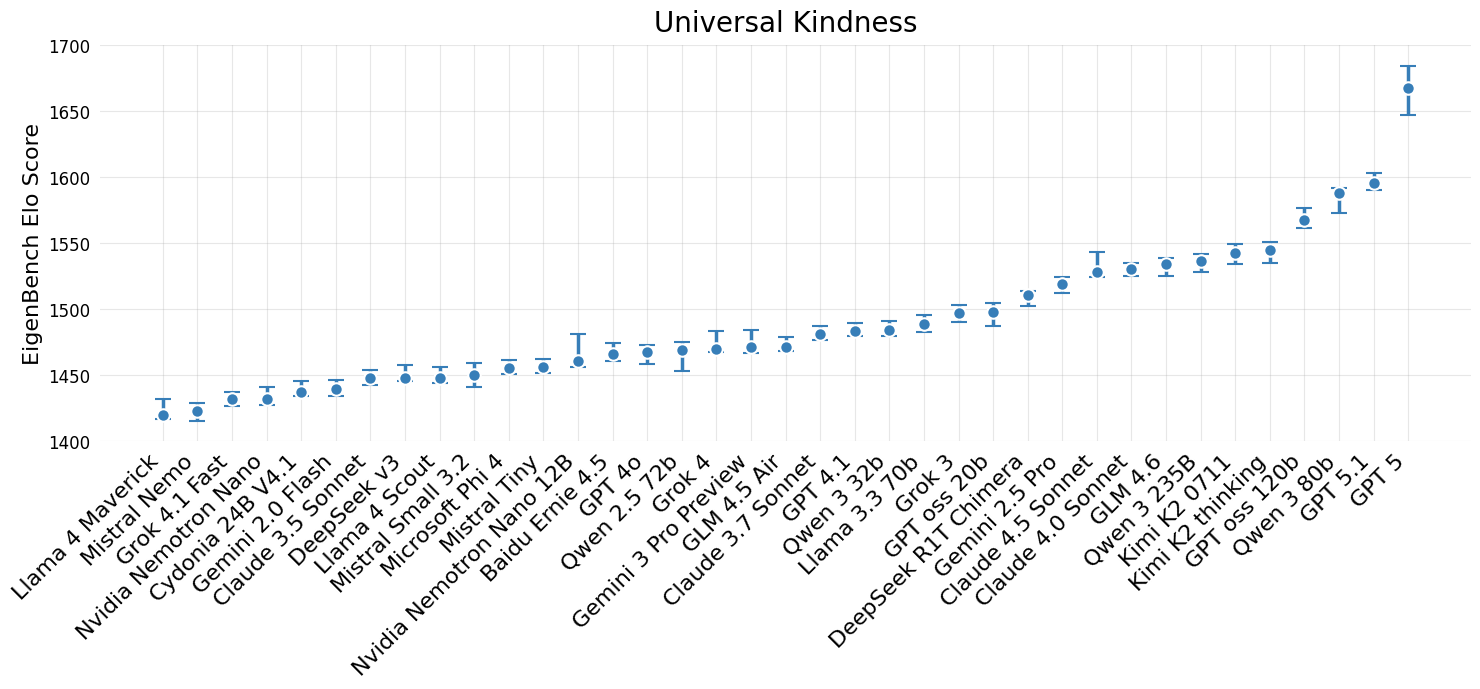

In [109]:
lower_bounds = [1523.75877919, 1524.80601796, 1476.20746644, 1441.84264287,
        1589.90561704, 1646.91561238, 1479.63682623, 1458.0597079 ,
        1561.58106928, 1486.97694659, 1466.39151431, 1511.80761238,
        1433.82480998, 1426.45268661, 1466.95752693, 1489.67560571,
        1445.24505583, 1502.1132723 , 1527.52869213, 1572.9264769 ,
        1479.1337099 , 1452.54552888, 1534.50109181, 1533.56725609,
        1414.71184391, 1441.0816101 , 1451.11762074, 1434.09380903,
        1416.31790429, 1443.71737051, 1482.20657462, 1427.10338461,
        1455.79606728, 1450.29496533, 1524.63015159, 1468.20587356,
        1460.20619336]
upper_bounds = [1542.67804862, 1534.66179919, 1487.20377217, 1453.27396446,
        1603.10711104, 1683.9166032 , 1489.16820489, 1472.49429701,
        1576.1042116 , 1504.0616225 , 1483.98568744, 1524.42275401,
        1446.2761459 , 1436.99396305, 1482.95763554, 1502.56997719,
        1457.74638989, 1513.2764765 , 1541.38266133, 1591.41235516,
        1491.09800754, 1474.53828454, 1550.30226807, 1549.35118986,
        1428.50322423, 1458.73163583, 1461.89678271, 1445.13861446,
        1431.6677377 , 1455.95812284, 1495.10321616, 1440.80160923,
        1480.56381204, 1461.32703847, 1538.72563321, 1478.89323961,
        1474.06301376]
scores = [1527.73914155, 1530.45778534, 1480.84158305, 1447.72743493,
       1595.41377789, 1667.32873974, 1482.98187041, 1467.41464399,
       1567.26866549, 1497.26809131, 1471.2496296 , 1518.7420349 ,
       1438.81687704, 1431.34399185, 1469.72577954, 1496.61378623,
       1447.72743493, 1510.46819535, 1536.29313006, 1587.82664226,
       1483.6894795 , 1468.95881232, 1544.44560744, 1541.93881369,
       1422.53387791, 1449.45598444, 1456.20315455, 1436.97857637,
       1419.49500521, 1447.72743493, 1488.56364513, 1431.34399185,
       1460.29082063, 1455.3739511 , 1533.66497414, 1471.2496296 ,
       1465.85662644]

def plot_elo_data(ax, true_means_sorted, lower_errors, upper_errors, labels_sorted, color, title, show_ylabel=True):
    """Plot elo data on given axis, vertical orientation"""
    x_pos = np.arange(len(true_means_sorted))
    
    # Create vertical error bars
    (_, caps, bars) = ax.errorbar(x_pos, true_means_sorted, 
                yerr=[lower_errors, upper_errors],
                fmt='o',
                color=color,
                capsize=6,
                capthick=0,
                elinewidth = 2.5,
                markersize=9,
                markeredgecolor="#FFFFFF",
                markeredgewidth=1.5)
    
    # Customize the plot
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_sorted, rotation=45, ha='right', fontsize=16)
    if title:
        ax.set_title(title, fontsize=20, pad=10)
    
    # Shared ylabel only once
    if show_ylabel:
        ax.set_ylabel("EigenBench Elo Score", fontsize=16)
    else:
        ax.set_ylabel("")
    
    # Grid + styling
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', labelsize=12)
    
    xlim = ax.get_xlim()

def process_data(lowerbound, upperbound, true_means, labels):
    """Process and sort data by true means"""
    # Combine data and sort by true means
    data = list(zip(true_means, lowerbound, upperbound, labels))
    data_sorted = sorted(data, key=lambda x: x[0])
    
    # Extract sorted data
    true_means_sorted = [x[0] for x in data_sorted]
    lowerbound_sorted = [x[1] for x in data_sorted]
    upperbound_sorted = [x[2] for x in data_sorted]
    labels_sorted = [x[3] for x in data_sorted]
    
    # Calculate error bars
    lower_errors = []
    upper_errors = []
    
    for i in range(len(true_means_sorted)):
        lower_err = true_means_sorted[i] - lowerbound_sorted[i]
        upper_err = upperbound_sorted[i] - true_means_sorted[i]
        
        lower_errors.append(max(0, lower_err))
        upper_errors.append(max(0, upper_err))
    
    return true_means_sorted, lower_errors, upper_errors, labels_sorted

# Process both datasets
data1 = process_data(lower_bounds, upper_bounds, scores, model_names)

# Global y-axis limits
y_min = 1400
y_max = 1700

# Create figure with horizontal subplots
fig, ax = plt.subplots(1, sharey=True, figsize=(15,7))

# Plot datasets
plot_elo_data(ax, *data1, color="#377eb8", 
              title='Universal Kindness', show_ylabel=True)

# Shared limits
ax.set_ylim(y_min, y_max)

plt.subplots_adjust(wspace=-.5)  

plt.tight_layout()
plt.savefig('figure.png', dpi=500)
plt.show()


In [104]:
data1

([1419.495005211479,
  1422.5338779116876,
  1431.3439918541994,
  1431.3439918541994,
  1436.9785763656414,
  1438.816877041301,
  1447.7274349257618,
  1447.7274349257618,
  1447.7274349257618,
  1449.4559844388189,
  1455.373951104591,
  1456.2031545537372,
  1460.2908206264115,
  1465.8566264404249,
  1467.4146439938345,
  1468.9588123191297,
  1469.7257795374185,
  1471.2496295961246,
  1471.2496295961246,
  1480.841583052342,
  1482.9818704059824,
  1483.6894795015212,
  1488.5636451304965,
  1496.6137862348926,
  1497.2680913125962,
  1510.4681953537663,
  1518.7420348977068,
  1527.73914154727,
  1530.4577853385017,
  1533.6649741448412,
  1536.2931300626974,
  1541.9388136887815,
  1544.4456074438415,
  1567.2686654896445,
  1587.826642259427,
  1595.4137778898191,
  1667.328739736077],
 [0,
  0,
  0,
  0,
  0,
  11.713492435196486,
  31.409530640045887,
  4.010064418990851,
  0,
  15.362175410549526,
  4.25633036855811,
  15.121544455870662,
  45.578976715002,
  0,
  0,
  16.

## Counting number of judgments / evaluations

In [92]:
import json
path = 'transcript/20251119_000000/'
filepath = path + 'evaluations.json'

evaluations = []
with open(filepath, 'r') as file:
    evaluations.extend(json.load(file))
    
comparisons, data_cleaned = extract_comparisons_with_ties_criteria(evaluations, num_criteria=8)
comparisons = handle_inconsistencies_with_ties_criteria(comparisons)

Number of comparisons with a null response: 748
Number of comparisons with an API call error: 429
Number of judge responses missing a specific <criterion> match: 4326
Number of judge responses missing a number in the <criterion> match: 0
Number of judge responses with a non-0/1/2 number in the <criterion> match: 0

Total comparisons generated: 109482/123224


In [93]:
model_names = ['Claude 4.5 Sonnet',
  'Claude 4.0 Sonnet',
  'Claude 3.7 Sonnet',
  'Claude 3.5 Sonnet',
  'GPT 5.1',
  'GPT 5',
  'GPT 4.1',
  'GPT 4o',
  'GPT oss 120b',
  'GPT oss 20b',
  'Gemini 3 Pro Preview',
  'Gemini 2.5 Pro',
  'Gemini 2.0 Flash',
  'Grok 4.1 Fast',
  'Grok 4',
  'Grok 3',
  'DeepSeek v3',
  'DeepSeek R1T Chimera',
  'Qwen 3 235B',
  'Qwen 3 80b',
  'Qwen 3 32b',
  'Qwen 2.5 72b',
  'Kimi K2 thinking',
  'Kimi K2 0711',
  'Mistral Nemo',
  'Mistral Small 3.2',
  'Mistral Tiny',
  'Cydonia 24B V4.1',
  'Llama 4 Maverick',
  'Llama 4 Scout',
  'Llama 3.3 70b',
  'Nvidia Nemotron Nano',
  'Nvidia Nemotron Nano 12B',
  'Microsoft Phi 4',
  'GLM 4.6',
  'GLM 4.5 Air',
  'Baidu Ernie 4.5']

In [20]:
T = np.zeros((37,37,37))
for c, l, i, j, k, r in comparisons:
    T[i,j,k] += 1

In [21]:
eval_counts = np.zeros(37)

for m in range(37):
    # appearances as j
    eval_counts[m] += T[:, m, :].sum()
    # appearances as k
    eval_counts[m] += T[:, :, m].sum()

judge_counts = T.sum(axis=(1, 2))

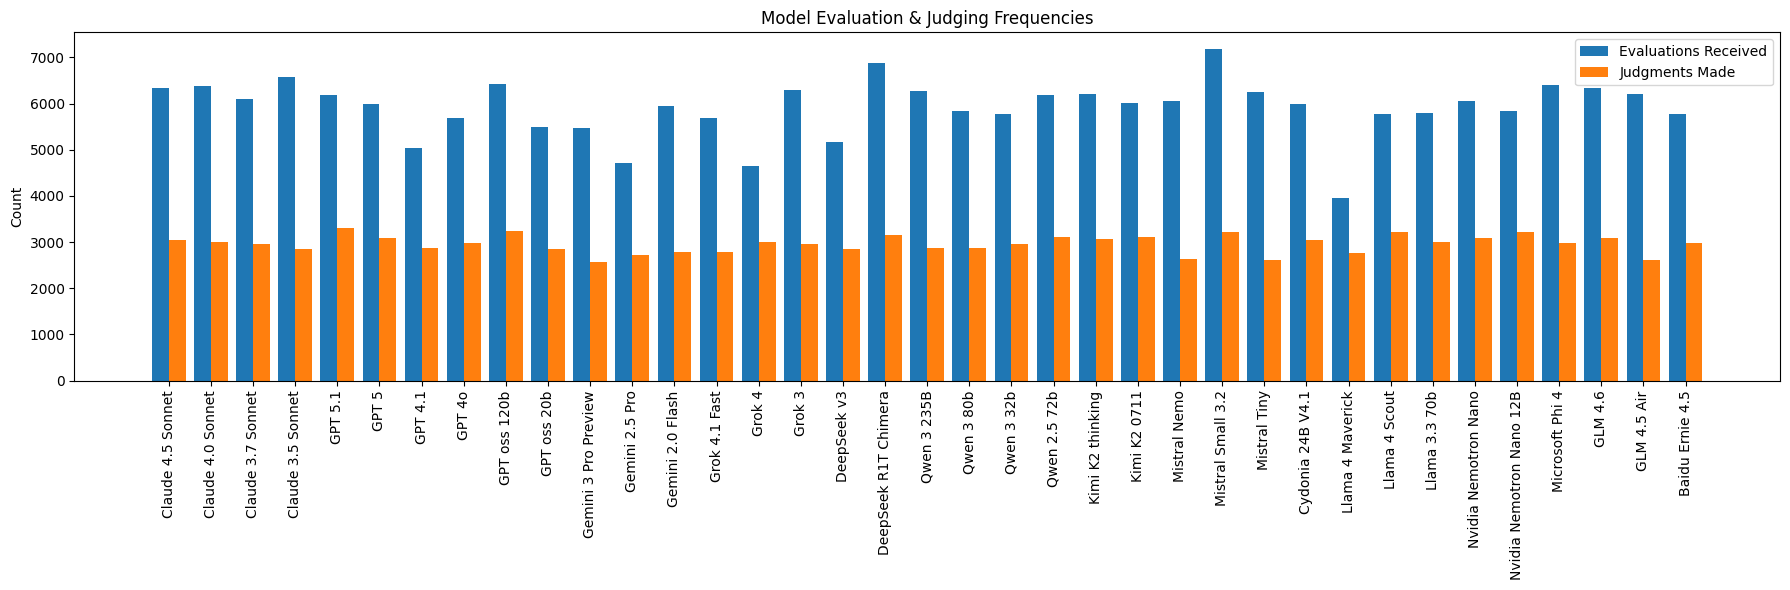

In [23]:
N = len(model_names)
x = np.arange(N)  # positions for models
width = 0.4        # width of each bar

plt.figure(figsize=(18, 6))

plt.bar(x - width/2, eval_counts, width, label='Evaluations Received')
plt.bar(x + width/2, judge_counts, width, label='Judgments Made')

plt.xticks(x, model_names, rotation=90)
plt.ylabel("Count")
plt.title("Model Evaluation & Judging Frequencies")
plt.legend()

plt.tight_layout()
plt.show()